In [2]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import numpy as np
from math import pi
from urllib.request import urlopen
import matplotlib.patheffects as pe
from highlight_text import fig_text
from adjustText import adjust_text
from tabulate import tabulate
import matplotlib.style as style
import unicodedata
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

style.use('fivethirtyeight')

from PIL import Image
import urllib
import os
import math
from PIL import Image
import matplotlib.image as image
pd.options.display.max_columns = None


warnings.filterwarnings('ignore') 

import sys
import os

# Add the directory containing FBREF_Aggregations.py to the Python path
module_path = os.path.abspath(os.path.join('/Users/stephenahiabah/Desktop/Code/cannoniq'))
if module_path not in sys.path:
    sys.path.append(module_path)

import FBREF_Aggregations as fbref
import PitchIQ_Plot as pitchiq



/Users/stephenahiabah/.pyenv/versions/3.11.0/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
def load_and_prepare_data():
    """
    Load and prepare goalkeeper data from FBref.
    """
    # URL for the goalkeepers' advanced stats page
    url = 'https://fbref.com/en/comps/Big5/keepersadv/players/Big-5-European-Leagues-Stats'

    # Fetch the page content and clean it
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(url).text.replace('<!--', '').replace('-->', '')

    # Parse the HTML tables into DataFrames
    gk_df = pd.read_html(html_content)

    # Select the last table (goalkeeper stats) and clean it
    gk_stats = gk_df[-1]
    gk_stats.columns = gk_stats.columns.droplevel(0)  # Drop the top header row
    gk_stats = gk_stats[gk_stats['Player'] != 'Player']  # Remove redundant rows

    # Handle duplicated columns
    cols = pd.Series(gk_stats.columns)
    for dup in cols[cols.duplicated()].unique():
        # Add a counter to duplicated columns (_2, _3, etc.)
        cols[cols[cols == dup].index.values.tolist()] = [dup + f'_{i}' if i != 0 else dup for i in range(sum(cols == dup))]
    
    # Assign the new column names to the DataFrame
    gk_stats.columns = cols

    # Rename columns to more descriptive names
    column_mapping = {
        'Rk': 'Rank',
        'Player': 'Player',
        'Nation': 'Nation',
        'Pos': 'Position',
        'Squad': 'Squad',
        'Comp': 'Competition',
        'Age': 'Age',
        'Born': 'Born',
        '90s': 'Minutes_90s',
        'GA': 'Goals_Against',
        'PKA': 'Penalty_Kicks_Allowed',
        'FK': 'Free_Kick_Goals_Against',
        'CK': 'Corner_Kick_Goals_Against',
        'OG': 'Own_Goals_Against',
        'PSxG': 'Post_Shot_Expected_Goals',
        'PSxG/SoT': 'Post_Shot_Expected_Goals_Per_Shot_On_Target',
        'PSxG+/-': 'Post_Shot_Expected_Goals_Minus_Goals_Allowed',
        '/90': 'Post_Shot_Expected_Goals_Minus_Goals_Allowed_Per_90',
        'Cmp': 'Launched_Passes_Completed',
        'Att': 'Launched_Passes_Attempted',  # First occurrence (launched passes)
        'Cmp%': 'Launched_Pass_Completion_Percentage',
        'Att (GK)': 'Passes_Attempted_Excluding_Goal_Kicks',
        'Thr': 'Throws_Attempted',
        'Launch%': 'Launched_Pass_Percentage',  # First occurrence (launched passes)
        'AvgLen': 'Average_Pass_Length',  # First occurrence (launched passes)
        'Att_1': 'Goal_Kicks_Launched_Attempted',  # Second occurrence (goal kicks)
        'Launch%_1': 'Goal_Kicks_Launched_Percentage',  # Second occurrence (goal kicks)
        'AvgLen_1': 'Average_Goal_Kick_Length',  # Second occurrence (goal kicks)
        'Opp': 'Crosses_Faced',
        'Stp': 'Crosses_Stopped',
        'Stp%': 'Crosses_Stopped_Percentage',
        '#OPA': 'Defensive_Actions_Outside_Penalty_Area',
        '#OPA/90': 'Defensive_Actions_Outside_Penalty_Area_Per_90',
        'AvgDist': 'Average_Distance_Of_Defensive_Actions',
        'Matches': 'Matches'
    }

    # Rename columns
    gk_stats.rename(columns=column_mapping, inplace=True)

    # List of columns to convert to numeric
    numeric_columns = [
        'Goals_Against', 'Penalty_Kicks_Allowed', 'Free_Kick_Goals_Against', 
        'Corner_Kick_Goals_Against', 'Own_Goals_Against', 'Post_Shot_Expected_Goals', 
        'Post_Shot_Expected_Goals_Per_Shot_On_Target', 'Post_Shot_Expected_Goals_Minus_Goals_Allowed', 
        'Post_Shot_Expected_Goals_Minus_Goals_Allowed_Per_90', 'Launched_Passes_Completed', 
        'Launched_Passes_Attempted', 'Launched_Pass_Completion_Percentage', 
        'Passes_Attempted_Excluding_Goal_Kicks', 'Throws_Attempted', 'Launched_Pass_Percentage', 
        'Average_Pass_Length', 'Crosses_Faced', 'Crosses_Stopped', 'Crosses_Stopped_Percentage', 
        'Defensive_Actions_Outside_Penalty_Area', 'Defensive_Actions_Outside_Penalty_Area_Per_90', 
        'Average_Distance_Of_Defensive_Actions', 'Minutes_90s'
    ]

    # Convert columns to numeric
    for col in numeric_columns:
        if col in gk_stats.columns:  # Ensure the column exists
            # # Clean the column by removing '+' and '-' signs
            # gk_stats[col] = gk_stats[col].astype(str).str.replace('+', '').str.replace('-', '')
            # # Convert to numeric
            gk_stats[col] = pd.to_numeric(gk_stats[col], errors='coerce')

    # Drop rows with missing values (if any)
    gk_stats.dropna(inplace=True)

    # Rename the leagues in the 'Comp' column
    league_name_mapping = {
        'es La Liga': 'La Liga',
        'eng Premier League': 'Premier League',
        'de Bundesliga': 'Bundesliga',
        'it Serie A': 'Serie A',
        'fr Ligue 1': 'Ligue 1'
    }
    gk_stats['Competition'] = gk_stats['Competition'].replace(league_name_mapping)

    # Apply per 90 normalization to count-based metrics
    per_90_columns = [
        'Goals_Against', 'Penalty_Kicks_Allowed', 'Free_Kick_Goals_Against', 
        'Corner_Kick_Goals_Against', 'Own_Goals_Against', 'Launched_Passes_Completed', 
        'Launched_Passes_Attempted', 'Passes_Attempted_Excluding_Goal_Kicks', 
        'Throws_Attempted', 'Crosses_Faced', 'Crosses_Stopped', 
        'Defensive_Actions_Outside_Penalty_Area'
    ]
    for col in per_90_columns:
        if col in gk_stats.columns:  # Ensure the column exists
            gk_stats[col] = gk_stats[col] / gk_stats['Minutes_90s']

    return gk_stats

In [4]:
gk_stats = load_and_prepare_data()

In [5]:
gk_stats

,Rank,Player,Nation,Position,Squad,Competition,Age,Born,Minutes_90s,Goals_Against,Penalty_Kicks_Allowed,Free_Kick_Goals_Against,Corner_Kick_Goals_Against,Own_Goals_Against,Post_Shot_Expected_Goals,Post_Shot_Expected_Goals_Per_Shot_On_Target,Post_Shot_Expected_Goals_Minus_Goals_Allowed,Post_Shot_Expected_Goals_Minus_Goals_Allowed_Per_90,Launched_Passes_Completed,Launched_Passes_Attempted,Launched_Pass_Completion_Percentage,Passes_Attempted_Excluding_Goal_Kicks,Throws_Attempted,Launched_Pass_Percentage,Average_Pass_Length,Goal_Kicks_Launched_Attempted,Goal_Kicks_Launched_Percentage,Average_Goal_Kick_Length,Crosses_Faced,Crosses_Stopped,Crosses_Stopped_Percentage,Defensive_Actions_Outside_Penalty_Area,Defensive_Actions_Outside_Penalty_Area_Per_90,Average_Distance_Of_Defensive_Actions,Matches
0,1,Adrián,es ESP,GK,Betis,La Liga,38-074,1987,9.0,1.333333,0.111111,0.000000,0.222222,0.000000,10.3,0.33,-1.7,-0.18,3.444444,9.444444,36.5,28.444444,4.444444,27.3,30.8,44,34.1,35.8,12.333333,0.555556,4.5,0.666667,0.67,13.0,Matches
1,2,Julen Agirrezabala,es ESP,GK,Athletic Club,La Liga,24-082,2000,13.4,0.671642,0.074627,0.149254,0.074627,0.000000,10.5,0.27,1.5,0.11,4.253731,13.283582,32.0,25.447761,3.805970,37.5,33.9,66,75.8,54.9,10.671642,1.492537,14.0,1.268657,1.27,14.2,Matches
2,3,Alisson,br BRA,GK,Liverpool,Premier League,32-167,1992,20.9,0.861244,0.000000,0.000000,0.047847,0.000000,17.7,0.28,-0.3,-0.01,2.488038,6.602871,37.7,28.181818,4.114833,20.4,26.5,54,33.3,30.7,9.473684,0.334928,3.5,1.866029,1.87,15.8,Matches
3,4,Alphonse Areola,fr FRA,GK,West Ham,Premier League,32-019,1993,17.1,1.695906,0.000000,0.000000,0.175439,0.175439,22.8,0.30,-3.2,-0.19,6.257310,16.023392,39.1,31.052632,4.561404,34.5,32.1,148,61.5,44.7,15.555556,0.701754,4.5,0.935673,0.94,12.9,Matches
4,5,Kepa Arrizabalaga,es ESP,GK,Bournemouth,Premier League,30-166,1994,22.0,1.318182,0.181818,0.000000,0.136364,0.000000,31.6,0.27,2.6,0.12,4.727273,12.681818,37.3,25.772727,3.590909,37.2,34.3,141,48.2,39.4,12.318182,0.590909,4.8,1.727273,1.73,16.2,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,189,Christian Walton,eng ENG,GK,Ipswich Town,Premier League,29-129,1995,6.0,2.666667,0.333333,0.000000,0.000000,0.000000,15.0,0.41,-1.0,-0.17,6.333333,18.000000,35.2,29.333333,4.500000,45.5,35.2,50,56.0,43.8,17.500000,1.833333,10.5,0.166667,0.17,7.6,Matches
196,190,Danny Ward,wls WAL,GK,Leicester City,Premier League,31-269,1993,1.5,4.000000,0.000000,0.000000,0.000000,0.000000,2.8,0.28,-3.2,-2.11,6.666667,14.666667,45.5,30.666667,6.000000,37.0,32.0,7,71.4,52.0,7.333333,0.000000,0.0,1.333333,1.33,20.7,Matches
197,191,Timon Weiner,de GER,GK,Holstein Kiel,Bundesliga,26-059,1999,25.0,2.440000,0.160000,0.080000,0.200000,0.080000,47.2,0.32,-11.8,-0.47,6.680000,17.760000,37.6,31.560000,4.640000,40.2,34.5,198,64.1,48.4,19.640000,1.080000,5.5,0.720000,0.72,11.1,Matches
198,192,Robin Zentner,de GER,GK,Mainz 05,Bundesliga,30-141,1994,26.0,1.076923,0.115385,0.076923,0.153846,0.000000,33.4,0.28,5.4,0.21,5.538462,18.000000,30.8,31.307692,4.384615,45.5,38.4,152,64.5,51.5,17.807692,1.576923,8.9,1.807692,1.81,13.6,Matches


In [6]:
pd.DataFrame(gk_stats['Competition'].unique()).to_csv('leagues.csv', index=False, header=['Competition'])

gk_stats['Competition'].unique()


array(['La Liga', 'Premier League', 'Bundesliga', 'Serie A', 'Ligue 1'],
      dtype=object)

In [7]:
# Filter the dataset for Premier League players
premier_league_gk_stats = gk_stats[gk_stats['Competition'] == 'Premier League']

In [8]:
premier_league_gk_stats

,Rank,Player,Nation,Position,Squad,Competition,Age,Born,Minutes_90s,Goals_Against,Penalty_Kicks_Allowed,Free_Kick_Goals_Against,Corner_Kick_Goals_Against,Own_Goals_Against,Post_Shot_Expected_Goals,Post_Shot_Expected_Goals_Per_Shot_On_Target,Post_Shot_Expected_Goals_Minus_Goals_Allowed,Post_Shot_Expected_Goals_Minus_Goals_Allowed_Per_90,Launched_Passes_Completed,Launched_Passes_Attempted,Launched_Pass_Completion_Percentage,Passes_Attempted_Excluding_Goal_Kicks,Throws_Attempted,Launched_Pass_Percentage,Average_Pass_Length,Goal_Kicks_Launched_Attempted,Goal_Kicks_Launched_Percentage,Average_Goal_Kick_Length,Crosses_Faced,Crosses_Stopped,Crosses_Stopped_Percentage,Defensive_Actions_Outside_Penalty_Area,Defensive_Actions_Outside_Penalty_Area_Per_90,Average_Distance_Of_Defensive_Actions,Matches
2,3,Alisson,br BRA,GK,Liverpool,Premier League,32-167,1992,20.9,0.861244,0.000000,0.000000,0.047847,0.000000,17.7,0.28,-0.3,-0.01,2.488038,6.602871,37.7,28.181818,4.114833,20.4,26.5,54,33.3,30.7,9.473684,0.334928,3.5,1.866029,1.87,15.8,Matches
3,4,Alphonse Areola,fr FRA,GK,West Ham,Premier League,32-019,1993,17.1,1.695906,0.000000,0.000000,0.175439,0.175439,22.8,0.30,-3.2,-0.19,6.257310,16.023392,39.1,31.052632,4.561404,34.5,32.1,148,61.5,44.7,15.555556,0.701754,4.5,0.935673,0.94,12.9,Matches
4,5,Kepa Arrizabalaga,es ESP,GK,Bournemouth,Premier League,30-166,1994,22.0,1.318182,0.181818,0.000000,0.136364,0.000000,31.6,0.27,2.6,0.12,4.727273,12.681818,37.3,25.772727,3.590909,37.2,34.3,141,48.2,39.4,12.318182,0.590909,4.8,1.727273,1.73,16.2,Matches
7,8,Brandon Austin,eng ENG,GK,Tottenham,Premier League,26-069,1999,1.0,2.000000,0.000000,0.000000,0.000000,0.000000,2.2,0.55,0.2,0.20,3.000000,11.000000,27.3,26.000000,5.000000,38.5,32.3,6,16.7,29.0,15.000000,5.000000,33.3,2.000000,2.00,12.4,Matches
38,38,Martin Dúbravka,sk SVK,GK,Newcastle Utd,Premier League,36-062,1989,10.0,1.200000,0.000000,0.000000,0.100000,0.000000,12.9,0.32,0.9,0.09,1.800000,8.000000,22.5,27.300000,5.400000,15.8,25.2,59,62.7,45.4,12.700000,1.000000,7.9,1.100000,1.10,15.3,Matches
39,39,Ederson,br BRA,GK,Manchester City,Premier League,31-213,1993,19.0,1.210526,0.105263,0.000000,0.105263,0.052632,25.7,0.36,3.7,0.20,3.157895,7.157895,44.1,34.210526,4.052632,18.9,28.0,56,23.2,31.2,8.736842,0.526316,6.0,1.894737,1.89,17.5,Matches
40,40,Łukasz Fabiański,pl POL,GK,West Ham,Premier League,39-334,1985,11.9,1.680672,0.252101,0.084034,0.252101,0.000000,22.3,0.30,2.3,0.19,5.798319,17.226891,33.7,30.168067,4.369748,41.5,35.4,94,59.6,44.4,16.638655,0.588235,3.5,0.924370,0.93,13.7,Matches
43,43,Mark Flekken,nl NED,GK,Brentford,Premier League,31-278,1993,27.4,1.569343,0.036496,0.000000,0.072993,0.072993,43.2,0.27,2.2,0.08,6.423358,17.299270,37.1,42.846715,3.503650,32.6,34.0,141,64.5,50.9,16.605839,1.350365,8.1,0.985401,0.99,11.4,Matches
45,45,Fraser Forster,eng ENG,GK,Tottenham,Premier League,37-001,1988,7.0,2.142857,0.285714,0.000000,0.142857,0.000000,16.5,0.36,1.5,0.21,1.571429,4.428571,35.5,20.142857,4.285714,21.3,27.2,56,1.8,14.6,11.571429,0.571429,4.9,0.428571,0.43,11.1,Matches
58,57,Dean Henderson,eng ENG,GK,Crystal Palace,Premier League,28-006,1997,28.0,1.178571,0.035714,0.000000,0.071429,0.071429,34.9,0.32,3.9,0.14,4.000000,15.714286,25.5,24.607143,3.071429,47.5,38.5,214,52.8,43.1,14.607143,0.714286,4.9,1.142857,1.14,14.6,Matches


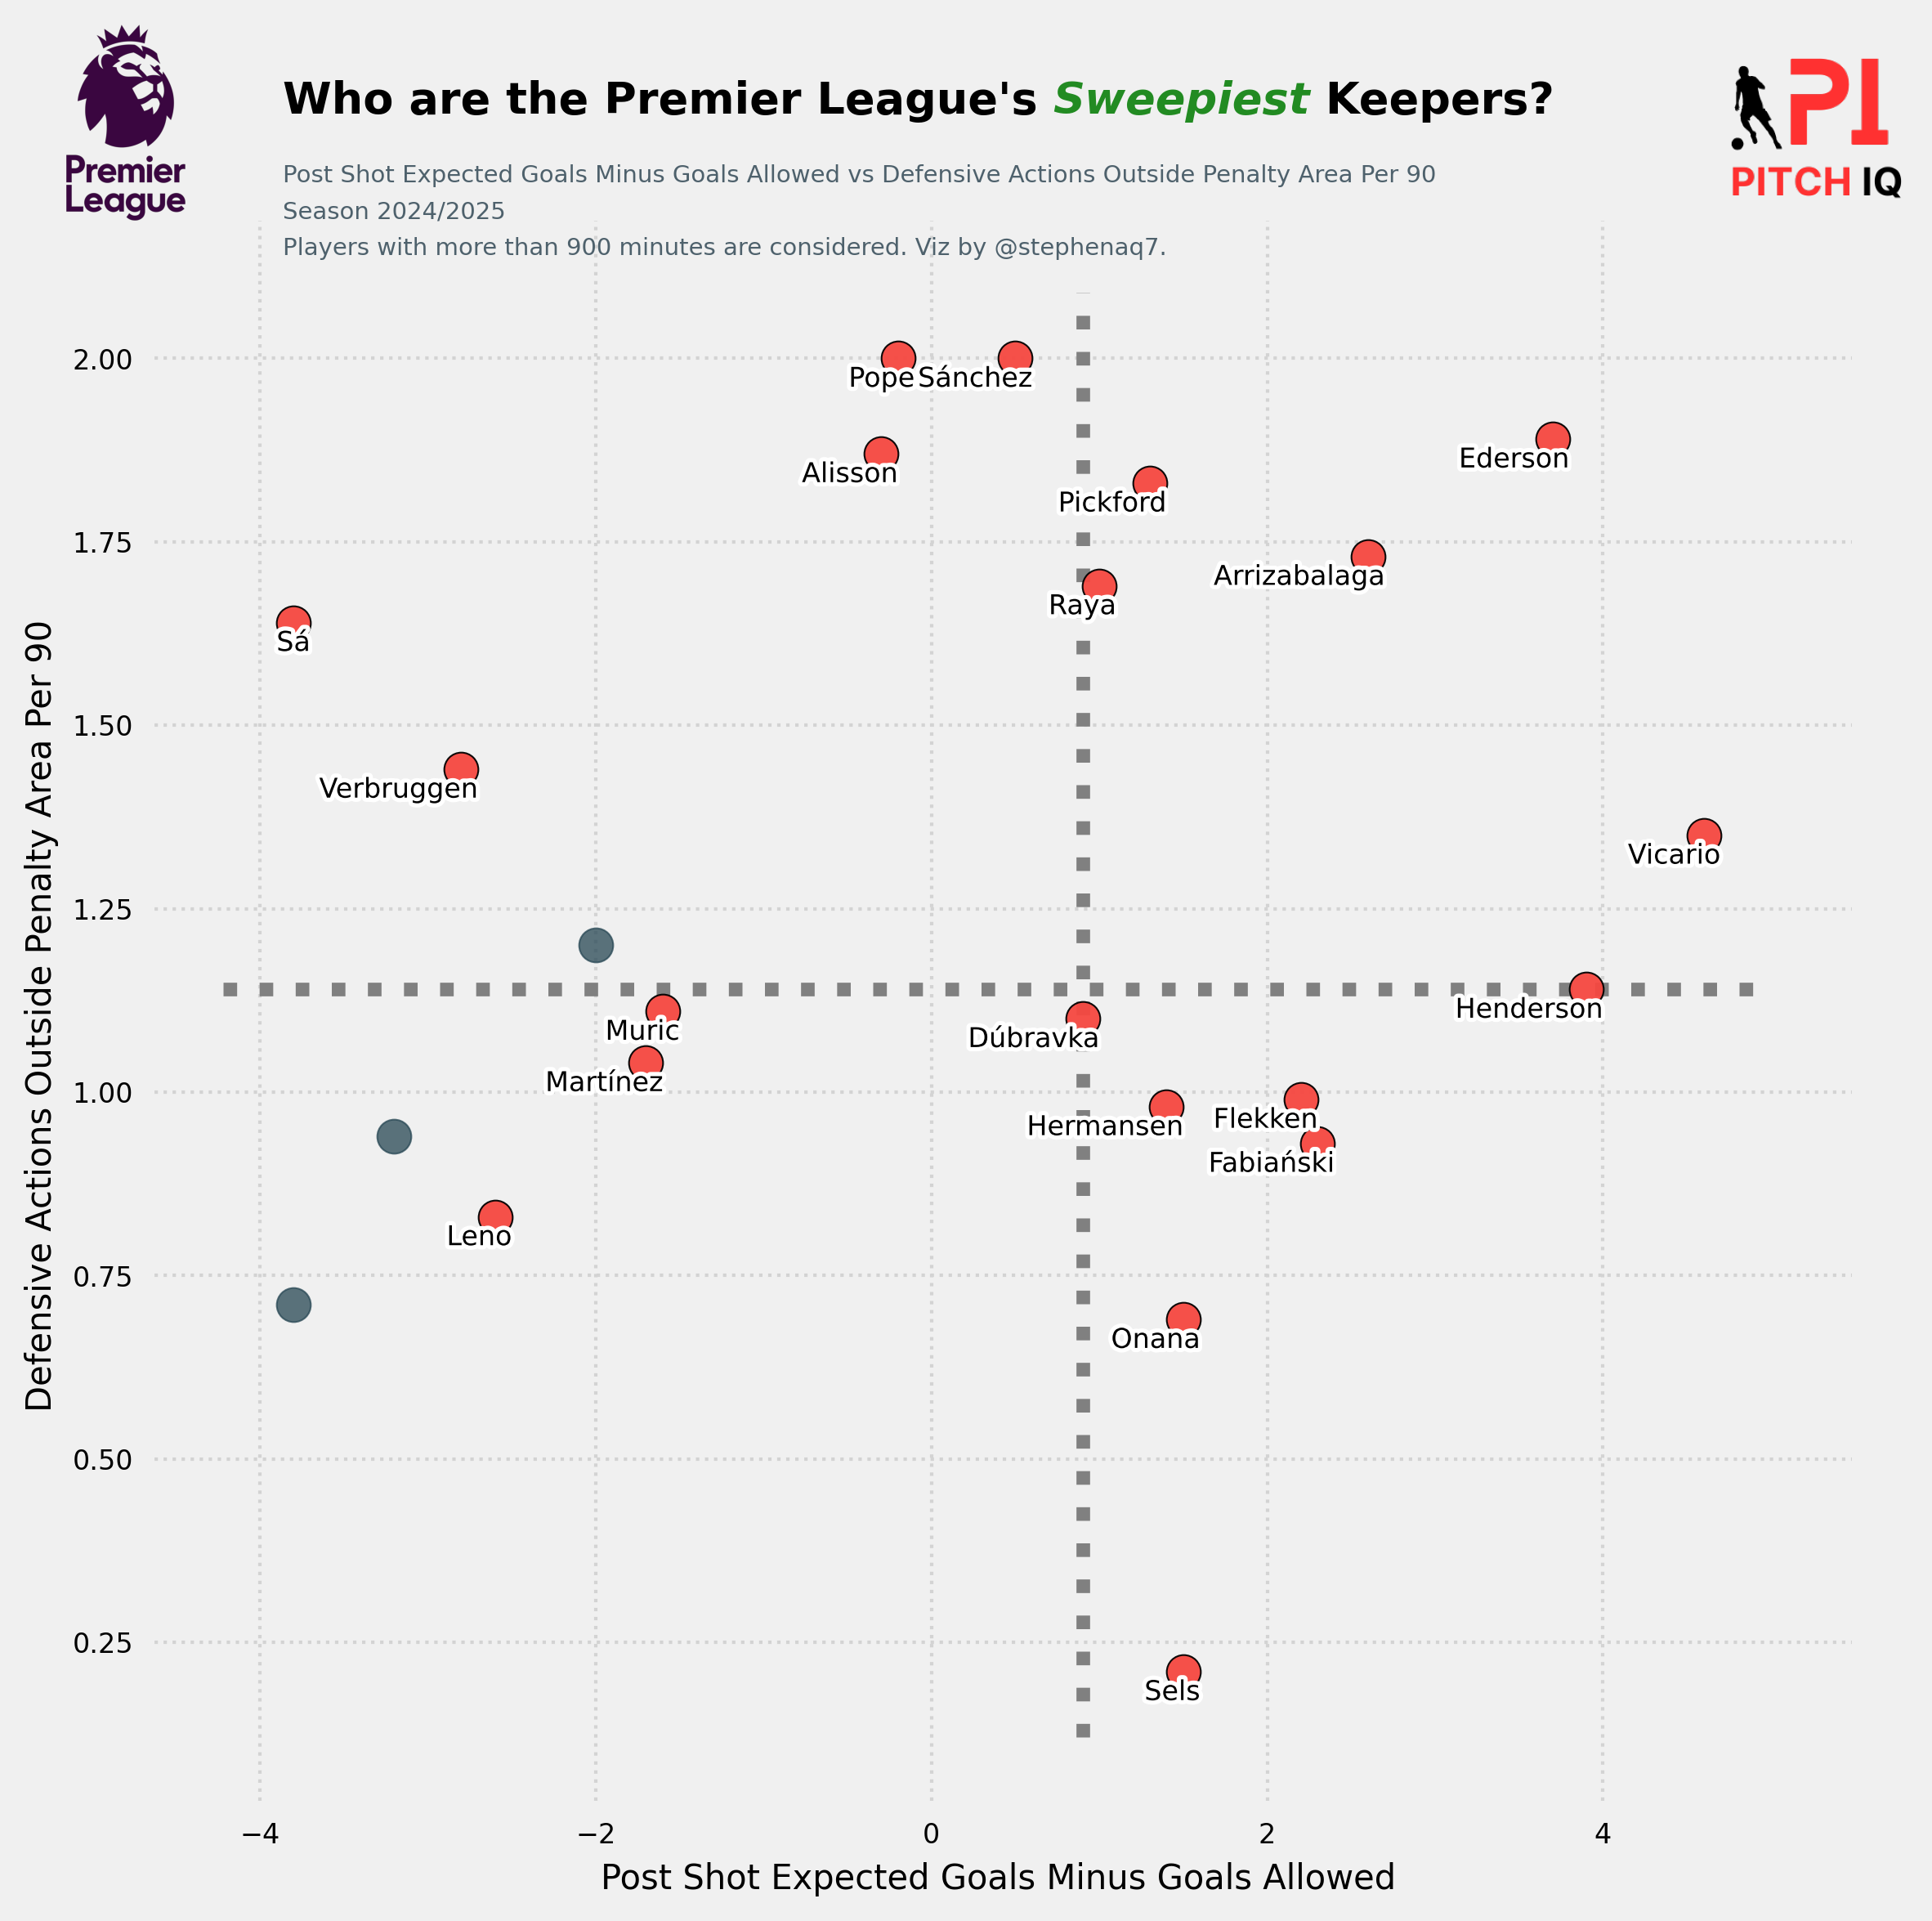

In [9]:
piq_plot = pitchiq.pitchiq_plot()

# Load your dataset (replace `your_dataset` with your actual DataFrame)


# Create a scatter plot
piq_plot.create_scatter_plot(
    data=premier_league_gk_stats,  # Your dataset
    metric='Post_Shot_Expected_Goals_Minus_Goals_Allowed_Per_90',  # Metric to rank players by

    x_var='Post_Shot_Expected_Goals_Minus_Goals_Allowed',  # X-axis variable
    y_var='Defensive_Actions_Outside_Penalty_Area_Per_90',  # Y-axis variable
    title="Who are the Premier League's <Sweepiest> Keepers?",  # Plot title
    top_n=20,  # Number of top players to highlight
    minutes_col='Minutes_90s',  # Column for minutes played
    min_minutes=10  # Minimum minutes played threshold
)

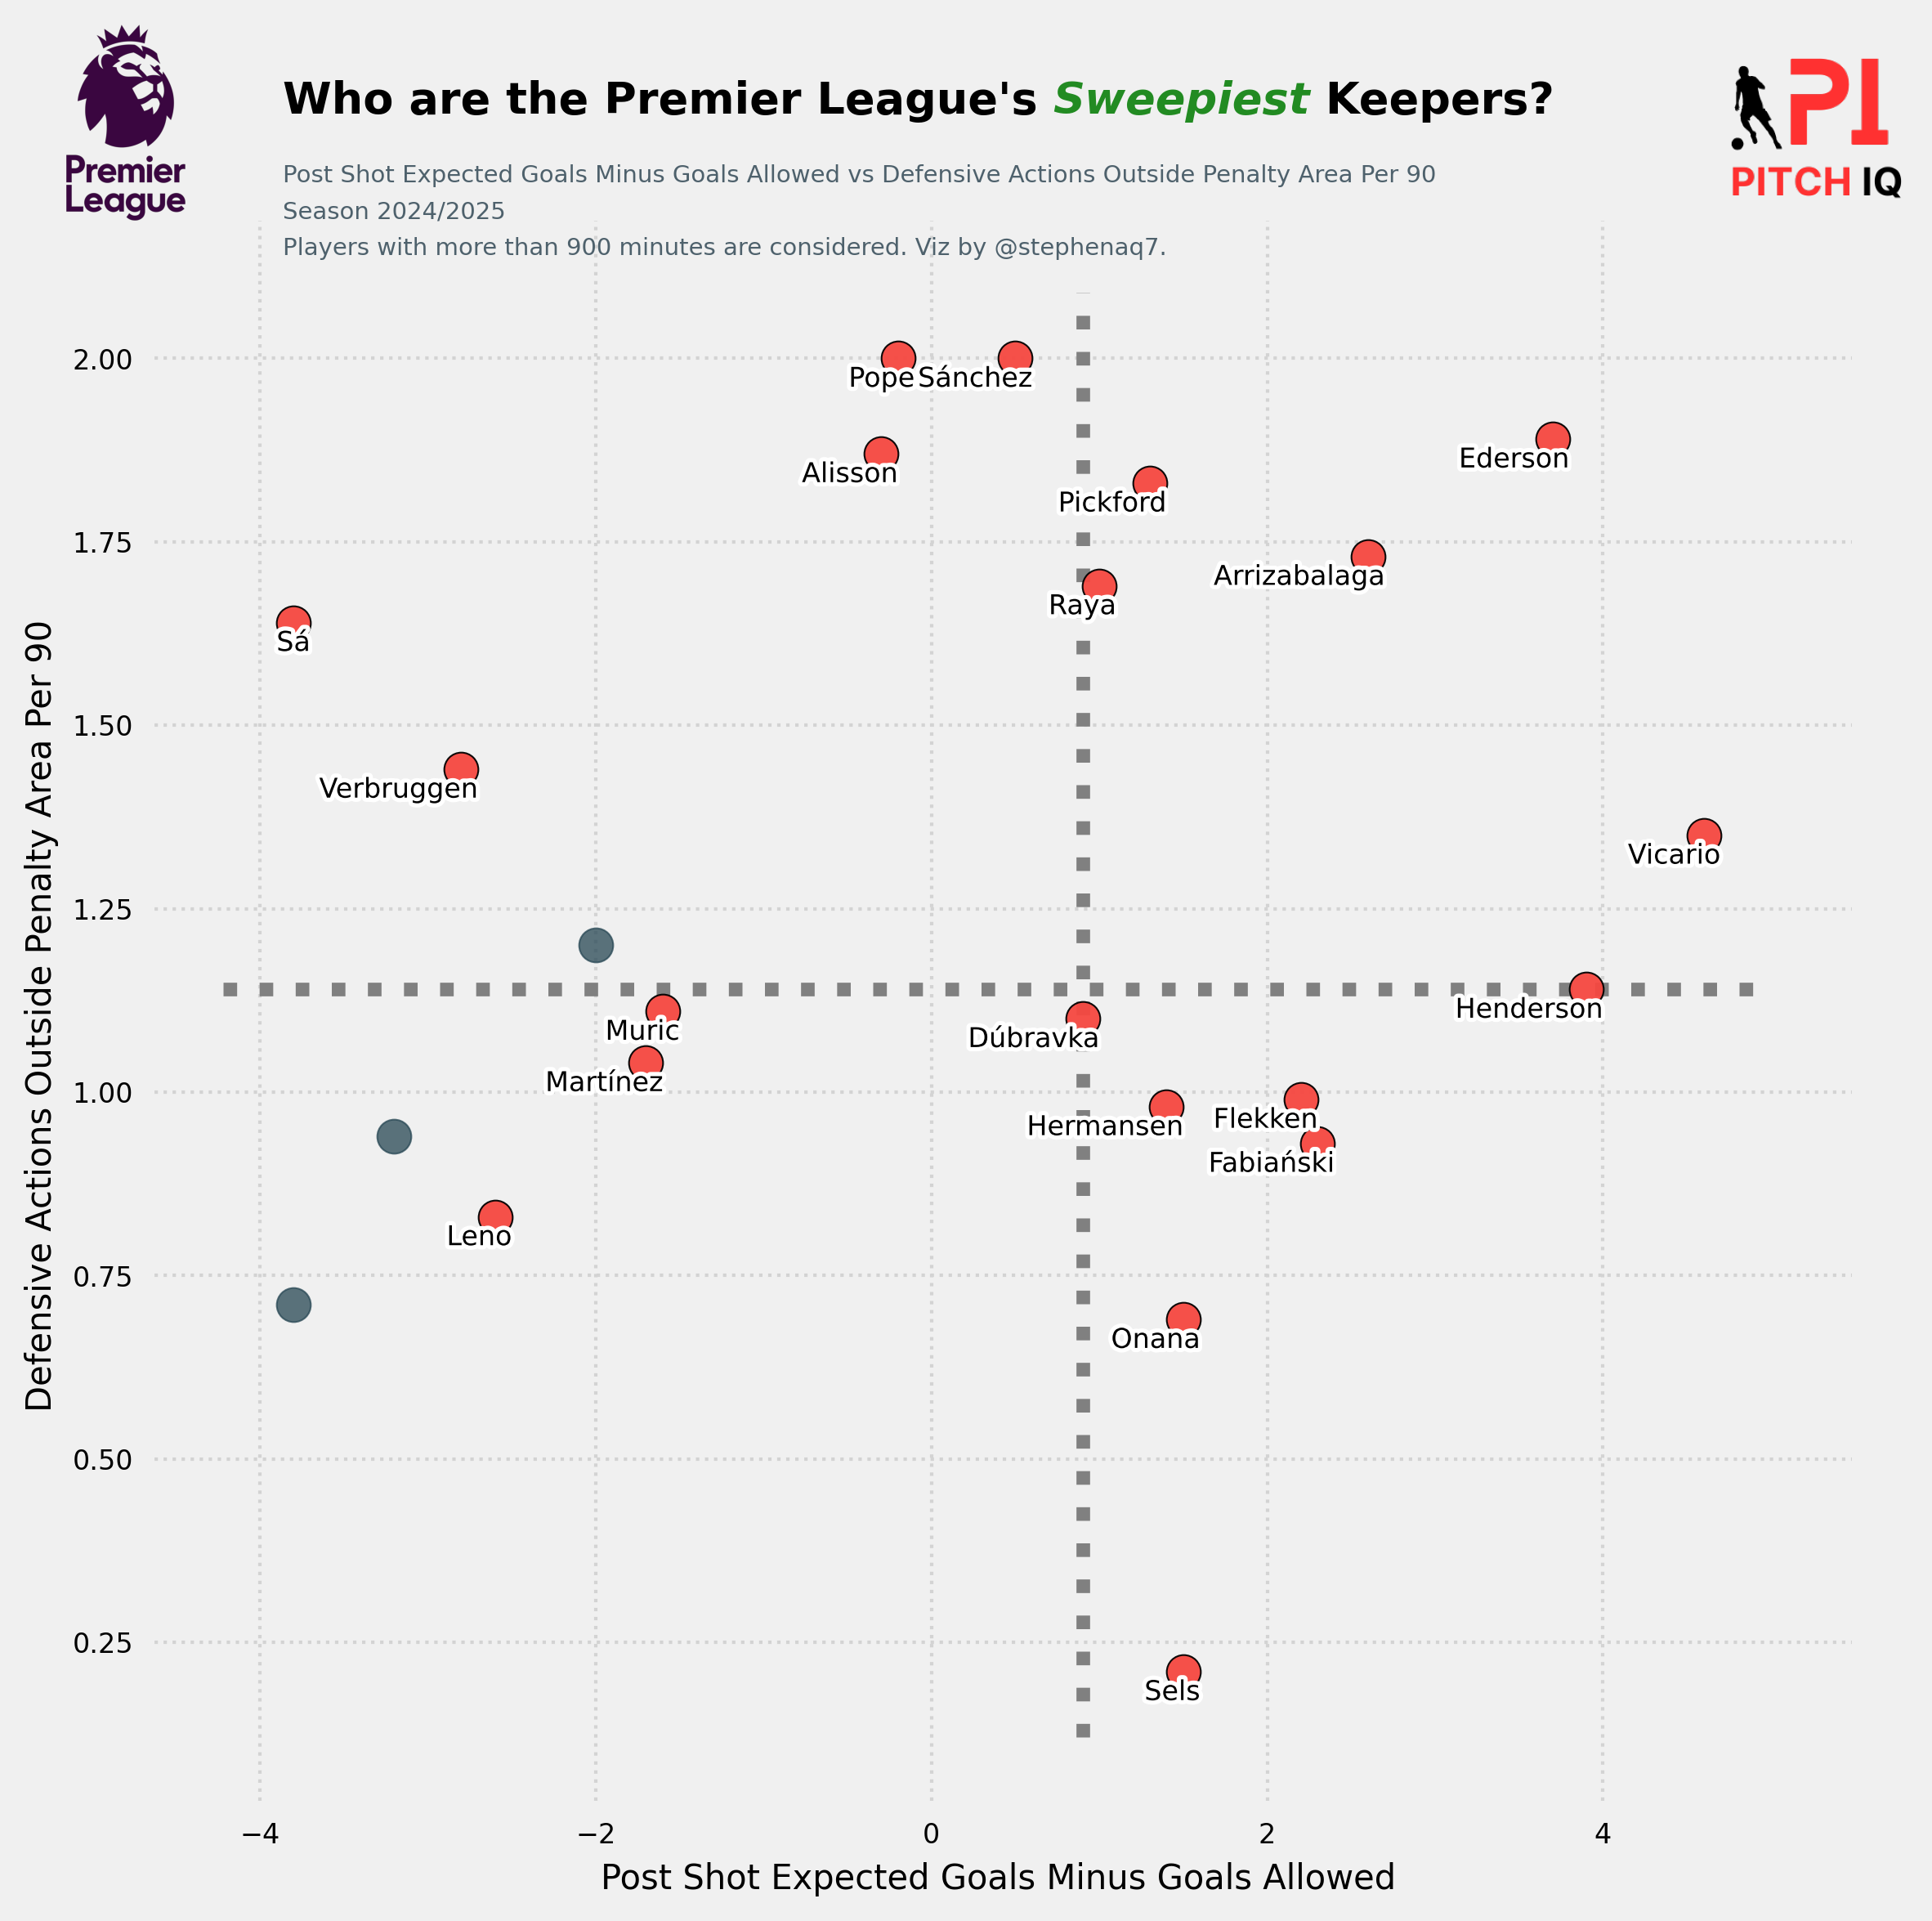

In [10]:
# Create a scatter plot
piq_plot.create_scatter_plot(
    data=premier_league_gk_stats,  # Your dataset
    metric='Post_Shot_Expected_Goals_Minus_Goals_Allowed_Per_90',  # Metric to rank players by

    x_var='Post_Shot_Expected_Goals_Minus_Goals_Allowed',  # X-axis variable
    y_var='Defensive_Actions_Outside_Penalty_Area_Per_90',  # Y-axis variable
    title="Who are the Premier League's <Sweepiest> Keepers?",  # Plot title
    top_n=20,  # Number of top players to highlight
    minutes_col='Minutes_90s',  # Column for minutes played
    min_minutes=10  # Minimum minutes played threshold
)

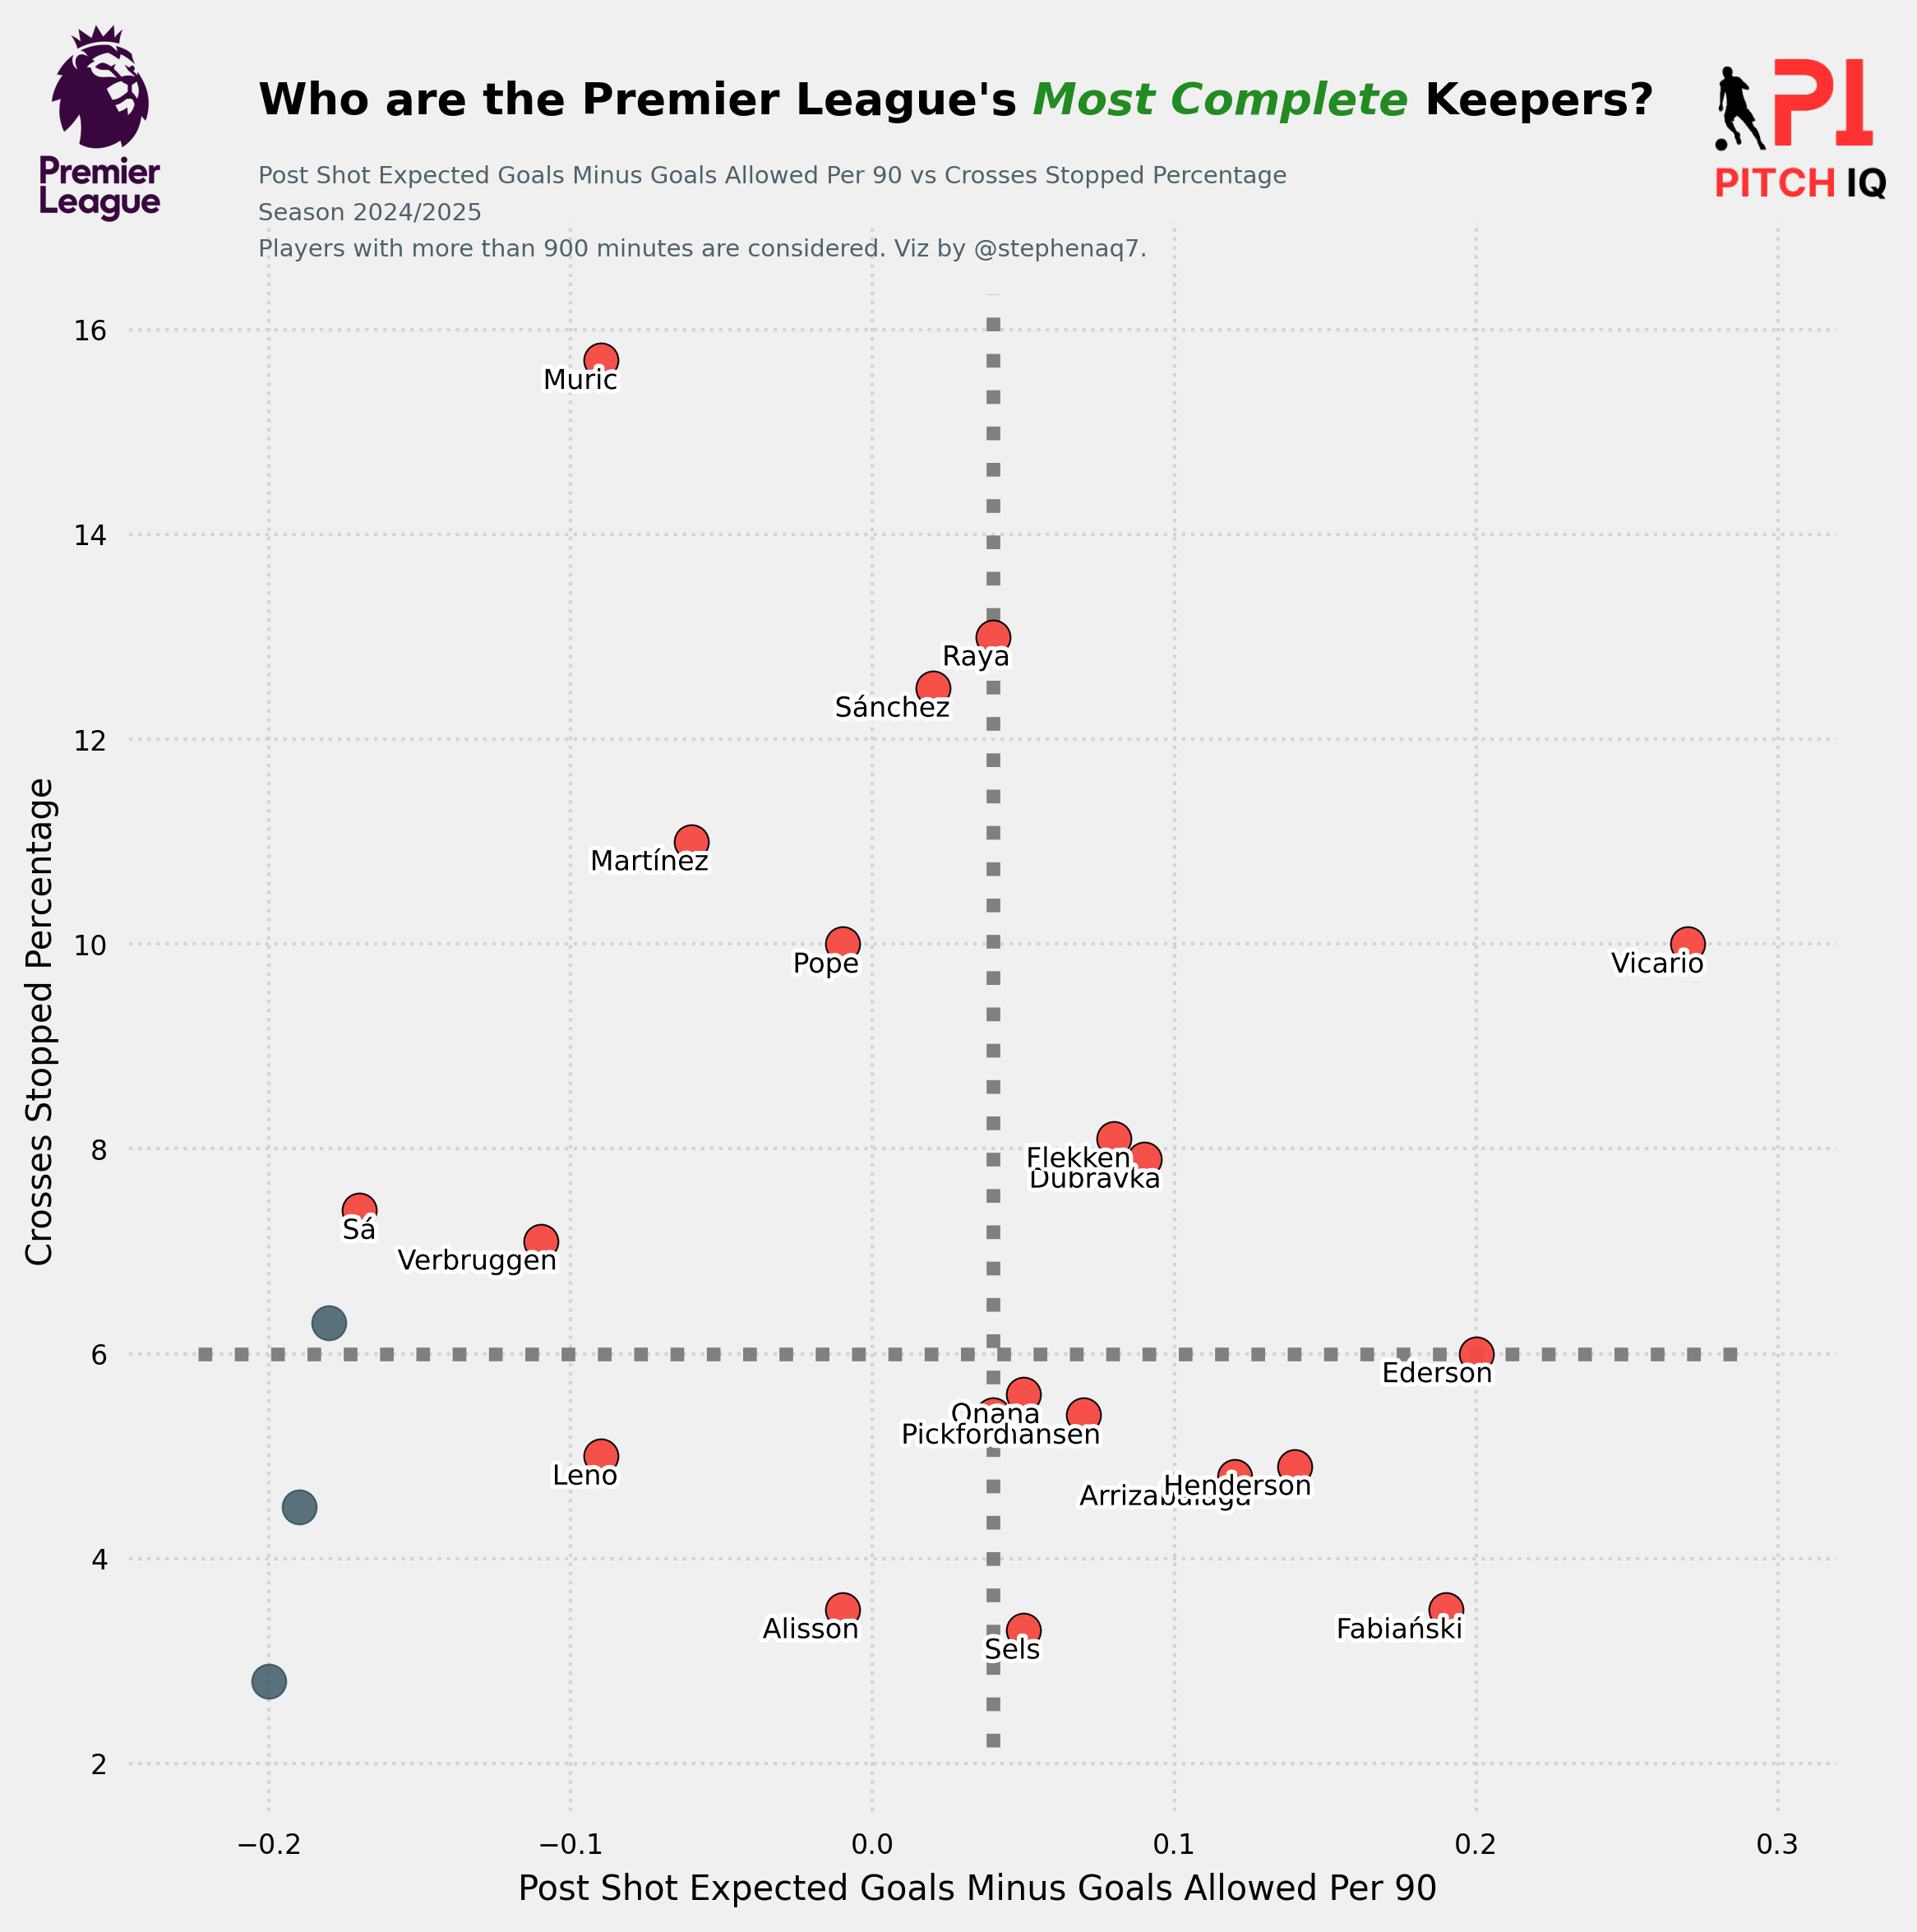

In [11]:
# Create a scatter plot
piq_plot.create_scatter_plot(
    data=premier_league_gk_stats,  # Your dataset
    metric='Post_Shot_Expected_Goals_Minus_Goals_Allowed_Per_90',  # Metric to rank players by
    x_var='Post_Shot_Expected_Goals_Minus_Goals_Allowed_Per_90',  # X-axis: Shot-stopping performance
    y_var='Crosses_Stopped_Percentage',  # Y-axis: Percentage of crosses stopped
    title="Who are the Premier League's <Most Complete> Keepers?",  # Plot title
    top_n=20,  # Number of top players to highlight
    minutes_col='Minutes_90s',  # Column for minutes played
    min_minutes=10  # Minimum minutes played threshold
)

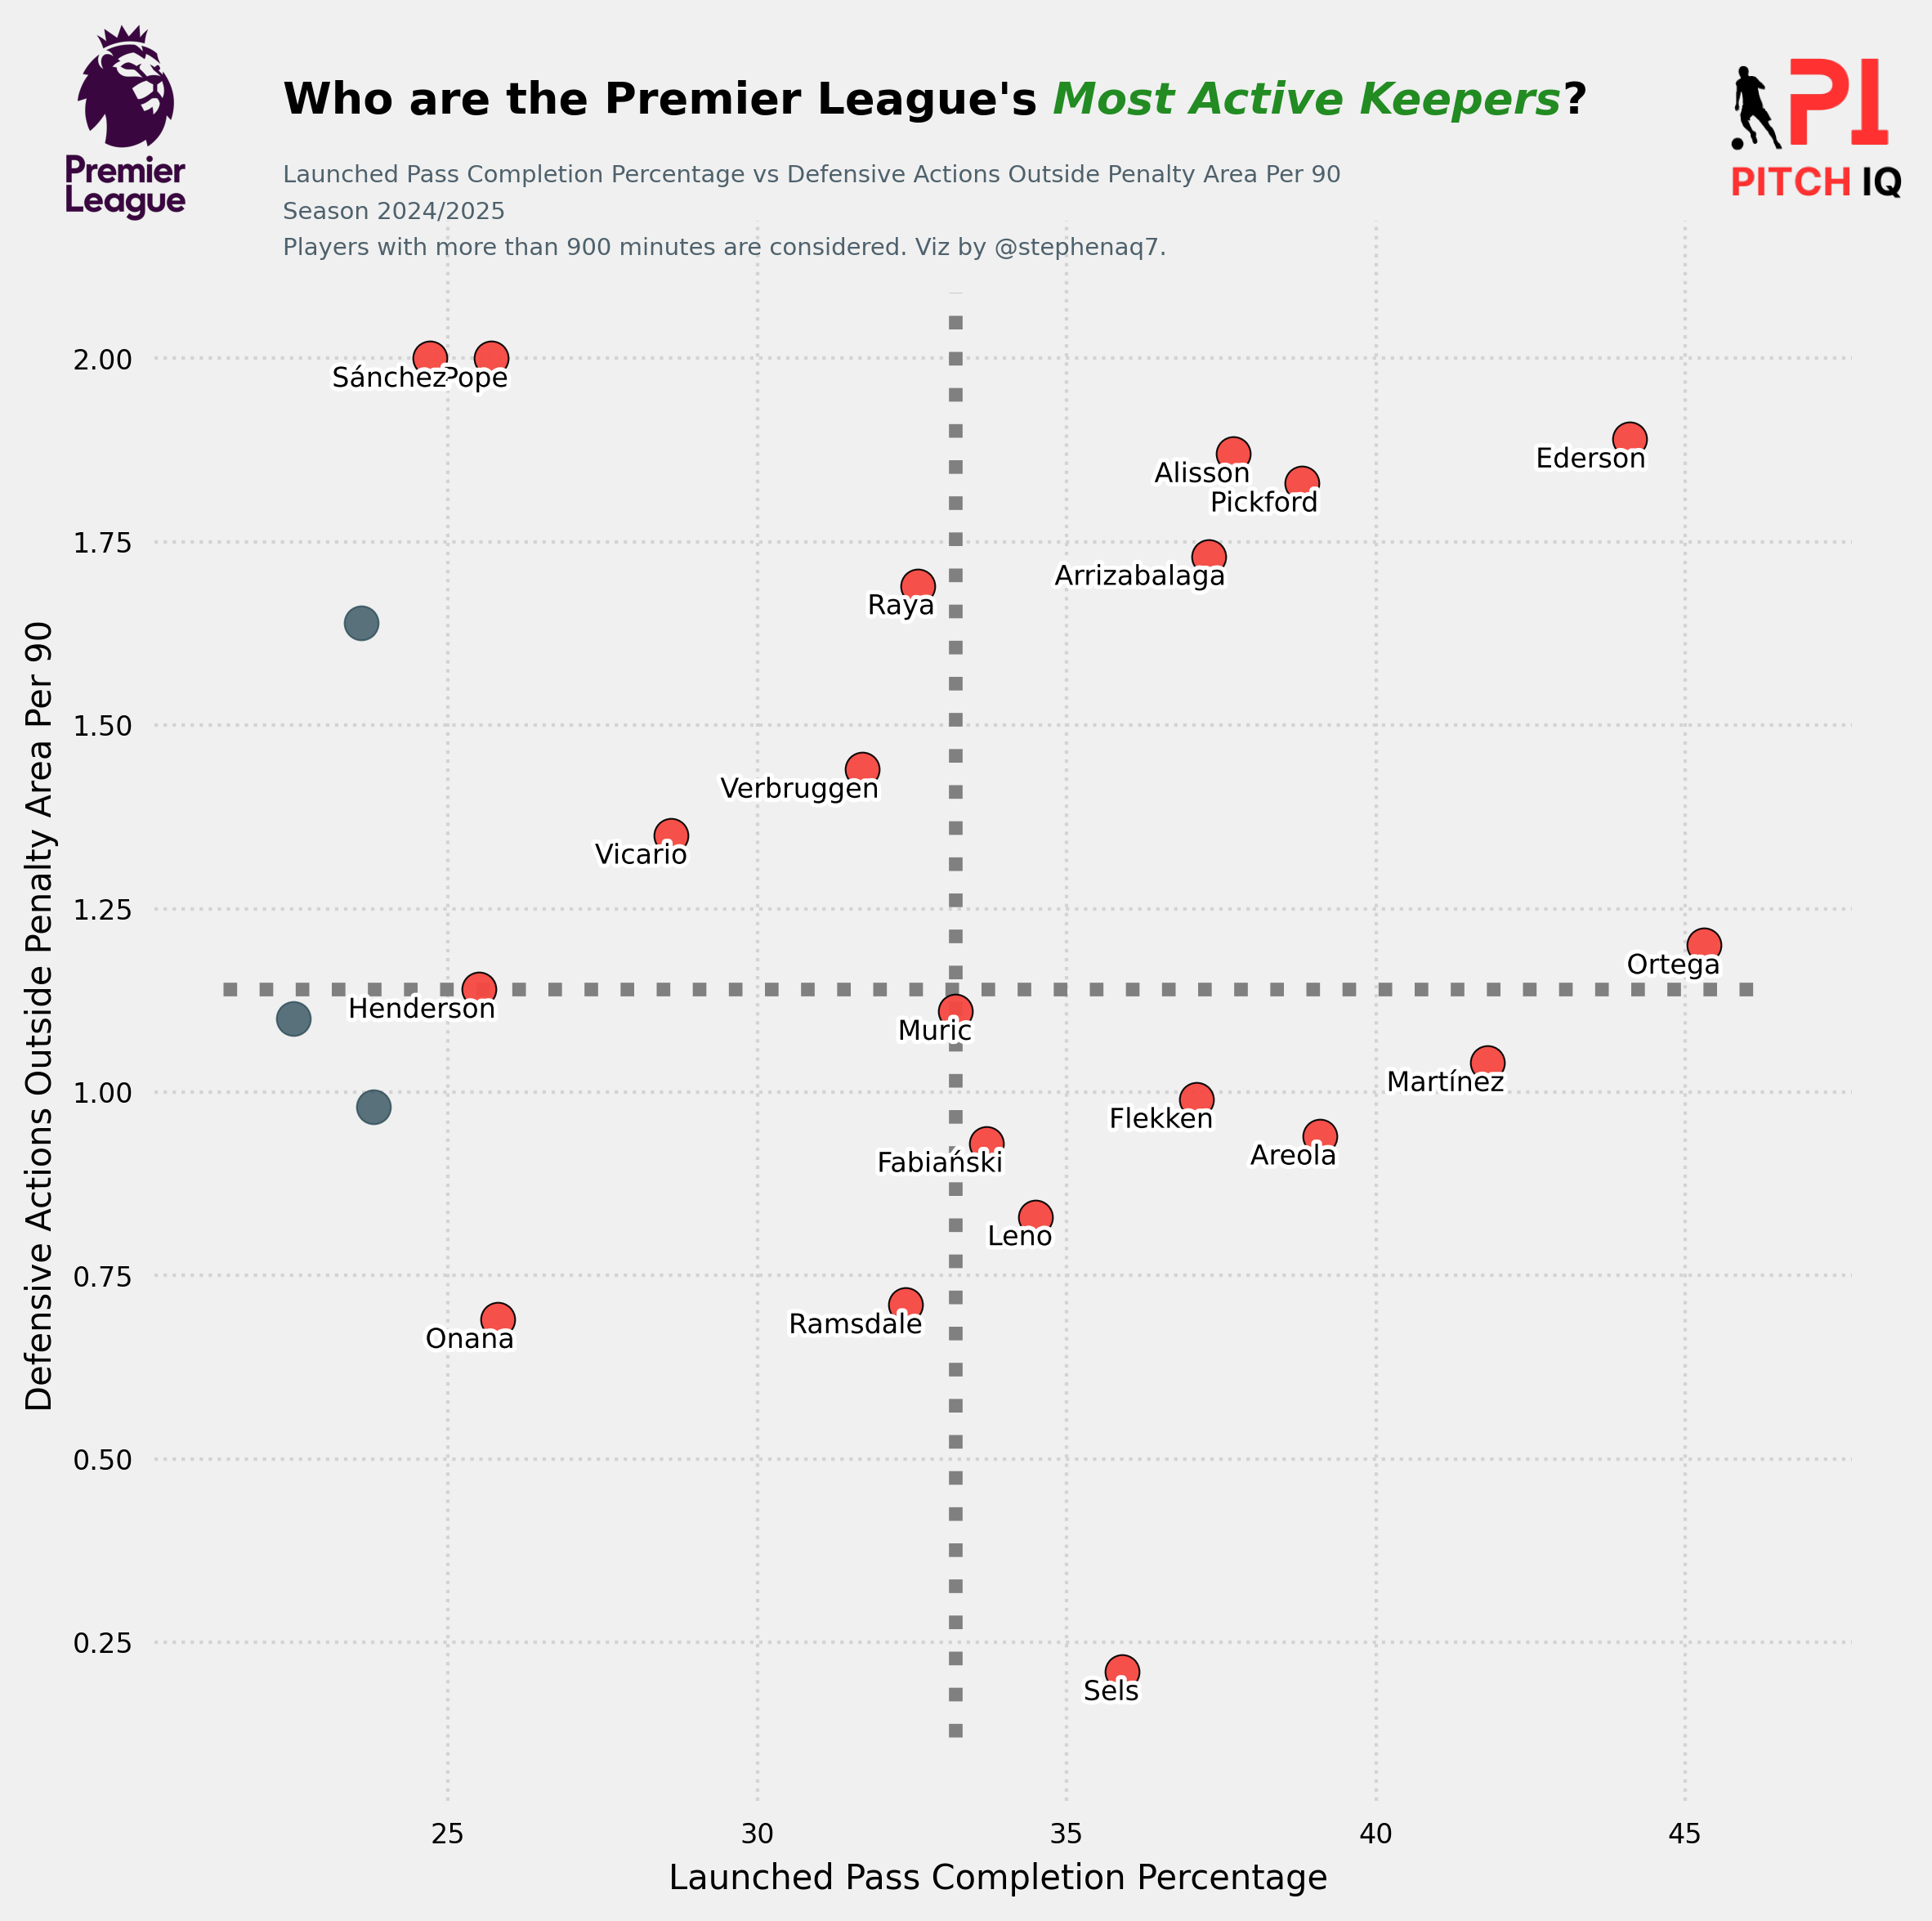

In [12]:
piq_plot.create_scatter_plot(
    data=premier_league_gk_stats,  # Your dataset
    metric='Launched_Pass_Completion_Percentage',  # Metric to rank players by
    x_var='Launched_Pass_Completion_Percentage',  # X-axis: Percentage of launched passes completed
    y_var='Defensive_Actions_Outside_Penalty_Area_Per_90',  # Y-axis: Defensive actions outside the box per 90
    title="Who are the Premier League's <Most Active Keepers>?",  # Plot title
    top_n=20,  # Number of top players to highlight
    minutes_col='Minutes_90s',  # Column for minutes played
    min_minutes=10  # Minimum minutes played threshold
)

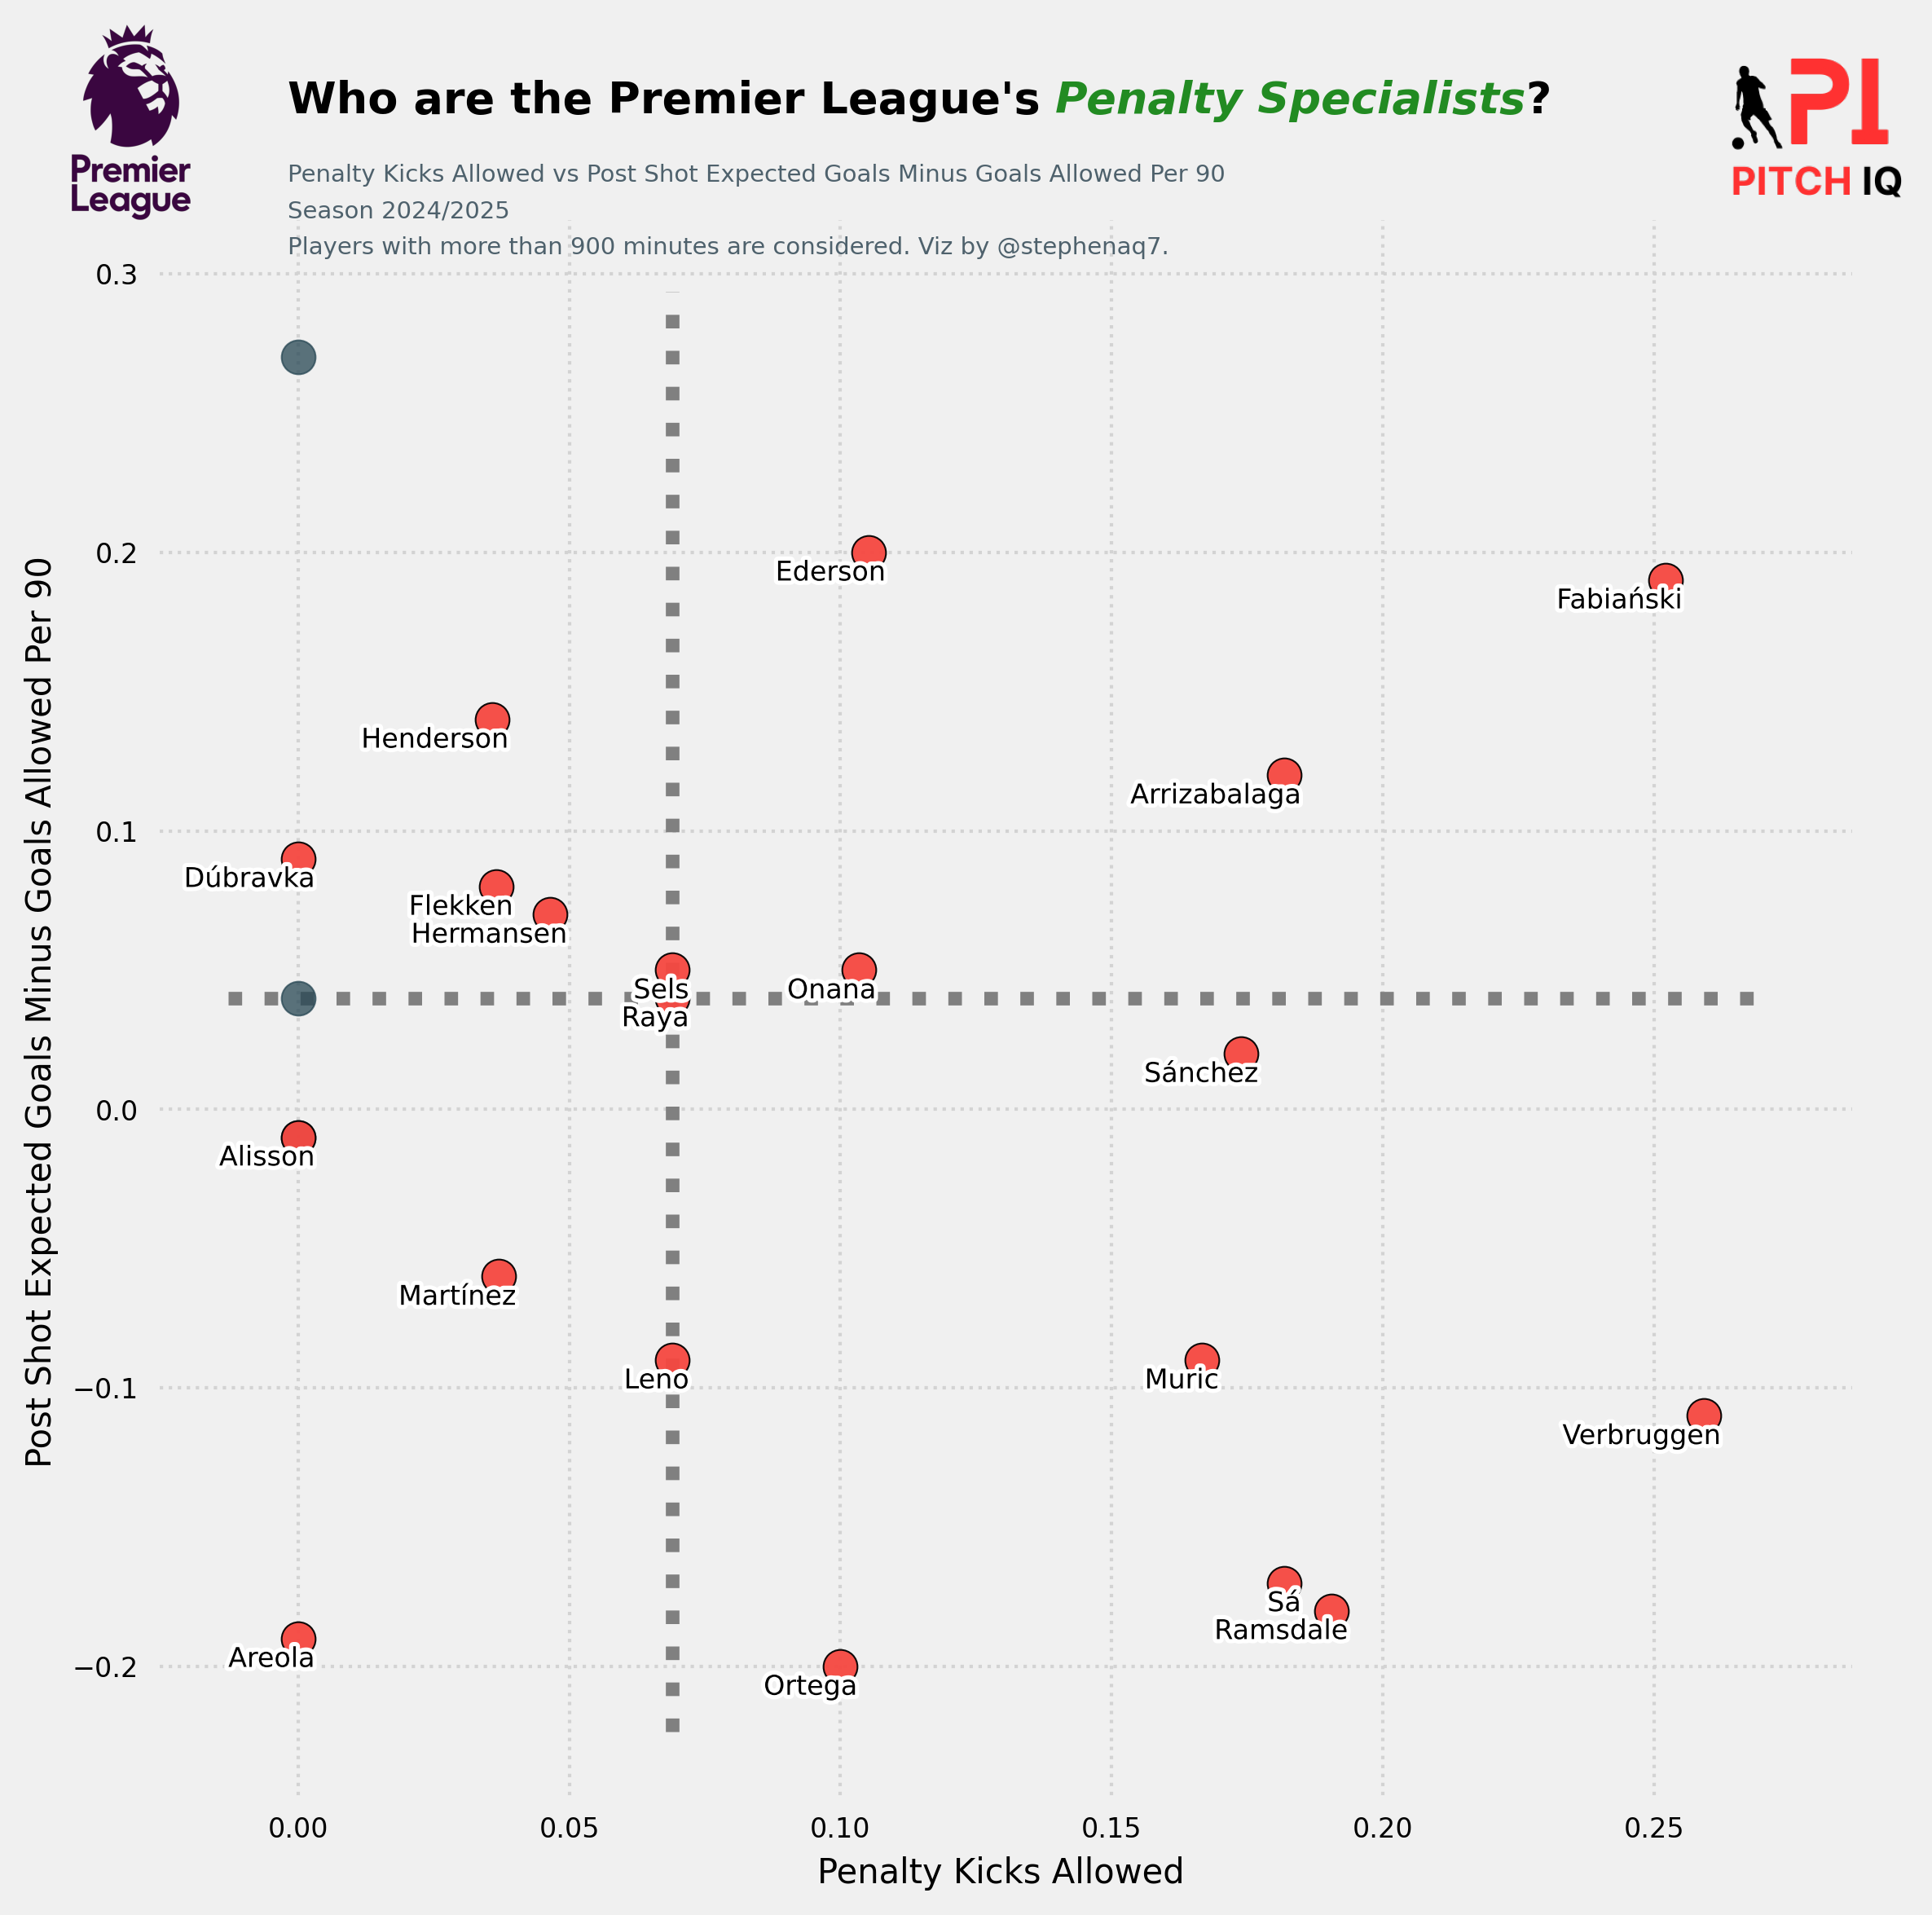

In [13]:
# Create a scatter plot
piq_plot.create_scatter_plot(
    data=premier_league_gk_stats,  # Your dataset
    metric='Penalty_Kicks_Allowed',  # Metric to rank players by
    x_var='Penalty_Kicks_Allowed',  # X-axis: Penalty kicks allowed
    y_var='Post_Shot_Expected_Goals_Minus_Goals_Allowed_Per_90',  # Y-axis: Shot-stopping performance
    title="Who are the Premier League's <Penalty Specialists>?",  # Plot title
    top_n=20,  # Number of top players to highlight
    minutes_col='Minutes_90s',  # Column for minutes played
    min_minutes=10  # Minimum minutes played threshold
)

In [14]:
from sklearn.preprocessing import MinMaxScaler

def standardise_ratings(gk_stats):
    """
    Calculate the CLOWN Rating for each goalkeeper.
    """
    # Normalize each stat to a 0–10 scale
    scaler = MinMaxScaler(feature_range=(0, 10))

    # Normalize Goals Conceded (higher is worse)
    gk_stats['Goals_Conceded_Norm'] = scaler.fit_transform(gk_stats[['Goals_Against']])

    # Normalize Goals Minus PSxG (negative values are worse)
    gk_stats['Goals_Minus_PSxG_Norm'] = scaler.fit_transform(gk_stats[['Post_Shot_Expected_Goals_Minus_Goals_Allowed']])

    # Normalize Own Goals (higher is worse)
    gk_stats['Own_Goals_Norm'] = scaler.fit_transform(gk_stats[['Own_Goals_Against']])

    # Normalize Save Percentage (lower is worse)
    gk_stats['Save_Percent_Norm'] = 10 - scaler.fit_transform(gk_stats[['Crosses_Stopped_Percentage']])

    # Normalize Pass Completion % (lower is worse)
    gk_stats['Pass_Completion_Norm'] = 10 - scaler.fit_transform(gk_stats[['Launched_Pass_Completion_Percentage']])

        # Assign weights to each component
    weights = {
        'Goals_Conceded_Norm': 0.2,
        'Goals_Minus_PSxG_Norm': 0.3,
        'Own_Goals_Norm': 0.2,
        'Save_Percent_Norm': 0.2,
        'Pass_Completion_Norm': 0.1
    }

    # Calculate the CLOWN Rating
    gk_stats['CLOWN_Rating'] = (
        gk_stats['Goals_Conceded_Norm'] * weights['Goals_Conceded_Norm'] +
        gk_stats['Goals_Minus_PSxG_Norm'] * weights['Goals_Minus_PSxG_Norm'] +
        gk_stats['Own_Goals_Norm'] * weights['Own_Goals_Norm'] +
        gk_stats['Save_Percent_Norm'] * weights['Save_Percent_Norm'] +
        gk_stats['Pass_Completion_Norm'] * weights['Pass_Completion_Norm']
    )

    # Round the CLOWN Rating for readability
    gk_stats['CLOWN_Rating'] = gk_stats['CLOWN_Rating'].round(2)


    return gk_stats

In [30]:
pl_clowns = gk_stats[gk_stats['Competition'] == 'Premier League']
pl_clowns = pl_clowns[gk_stats['Minutes_90s'] > 0]
pl_clowns = standardise_ratings(pl_clowns)

In [33]:
pl_clowns.to_csv('pl_clowns.csv', index=False)

In [17]:
def apply_clustering(gk_df, max_clusters=10):
    """
    Apply K-Means clustering to group goalkeepers and determine the optimal number of clusters using the Elbow Method.
    """
    # Select features for clustering
    features = ['Goals_Conceded_Norm', 'Goals_Minus_PSxG_Norm', 'Own_Goals_Norm', 'Save_Percent_Norm', 'Pass_Completion_Norm']
    X = gk_df[features]

    # Calculate WCSS for different numbers of clusters
    wcss = []
    for n in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  # Inertia is the WCSS

    # Plot the Elbow Method graph
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
    plt.show()

    # Ask the user to input the optimal number of clusters
    n_clusters = int(input("Enter the optimal number of clusters based on the Elbow Method: "))

    # Apply K-Means clustering with the chosen number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    gk_df['Cluster'] = kmeans.fit_predict(X)

    return gk_df

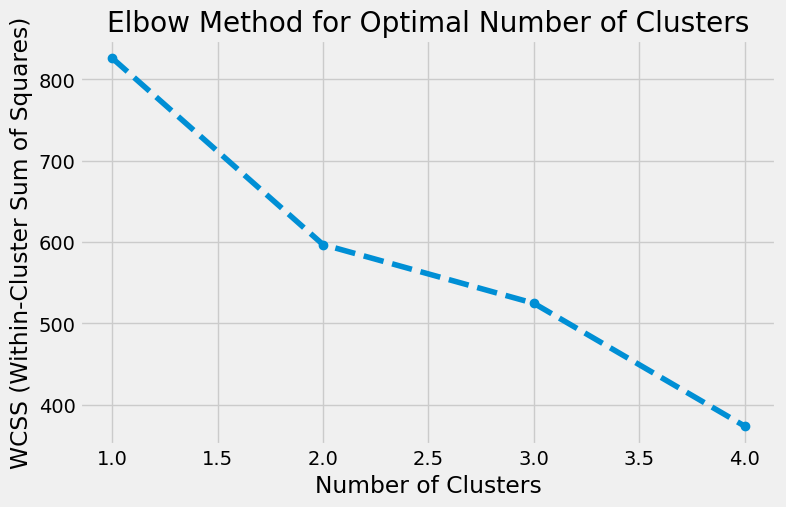

In [19]:
pl_clowns_cluster = apply_clustering(pl_clowns, max_clusters=4)

In [20]:
def analyze_feature_importance(gk_df):
    """
    Analyze feature importance using Random Forest.
    """
    # Select features and target
    features = ['Goals_Conceded_Norm', 'Goals_Minus_PSxG_Norm', 'Own_Goals_Norm', 'Save_Percent_Norm', 'Pass_Completion_Norm']
    X = gk_df[features]
    y = gk_df['CLOWN_Rating']

    # Train a Random Forest model
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)

    # Get feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    return feature_importance_df

In [21]:
analyze_feature_importance(pl_clowns_cluster)

,Feature,Importance
1,Goals_Minus_PSxG_Norm,0.406931
3,Save_Percent_Norm,0.281256
4,Pass_Completion_Norm,0.168900
0,Goals_Conceded_Norm,0.077232
2,Own_Goals_Norm,0.065681


In [22]:
def calculate_clown_rating(gk_stats):

    # Analyze feature importance to get dynamic weights
    feature_importance_df = analyze_feature_importance(gk_stats)
    weights = dict(zip(feature_importance_df['Feature'], feature_importance_df['Importance']))

    # Calculate the CLOWN Rating using dynamic weights
    gk_stats['CLOWN_Rating'] = (
        gk_stats['Goals_Conceded_Norm'] * weights['Goals_Conceded_Norm'] +
        gk_stats['Goals_Minus_PSxG_Norm'] * weights['Goals_Minus_PSxG_Norm'] +
        gk_stats['Own_Goals_Norm'] * weights['Own_Goals_Norm'] +
        gk_stats['Save_Percent_Norm'] * weights['Save_Percent_Norm'] +
        gk_stats['Pass_Completion_Norm'] * weights['Pass_Completion_Norm']
    )

    # Round the CLOWN Rating for readability
    gk_stats['CLOWN_Rating'] = gk_stats['CLOWN_Rating'].round(2)

    return gk_stats

In [23]:
pl_clowns_cluster = calculate_clown_rating(pl_clowns_cluster)

In [24]:
pl_clowns_cluster

,Rank,Player,Nation,Position,Squad,Competition,Age,Born,Minutes_90s,Goals_Against,Penalty_Kicks_Allowed,Free_Kick_Goals_Against,Corner_Kick_Goals_Against,Own_Goals_Against,Post_Shot_Expected_Goals,Post_Shot_Expected_Goals_Per_Shot_On_Target,Post_Shot_Expected_Goals_Minus_Goals_Allowed,Post_Shot_Expected_Goals_Minus_Goals_Allowed_Per_90,Launched_Passes_Completed,Launched_Passes_Attempted,Launched_Pass_Completion_Percentage,Passes_Attempted_Excluding_Goal_Kicks,Throws_Attempted,Launched_Pass_Percentage,Average_Pass_Length,Goal_Kicks_Launched_Attempted,Goal_Kicks_Launched_Percentage,Average_Goal_Kick_Length,Crosses_Faced,Crosses_Stopped,Crosses_Stopped_Percentage,Defensive_Actions_Outside_Penalty_Area,Defensive_Actions_Outside_Penalty_Area_Per_90,Average_Distance_Of_Defensive_Actions,Matches,Goals_Conceded_Norm,Goals_Minus_PSxG_Norm,Own_Goals_Norm,Save_Percent_Norm,Pass_Completion_Norm,CLOWN_Rating,Cluster
2,3,Alisson,br BRA,GK,Liverpool,Premier League,32-167,1992,20.9,0.861244,0.000000,0.000000,0.047847,0.000000,17.7,0.28,-0.3,-0.01,2.488038,6.602871,37.7,28.181818,4.114833,20.4,26.5,54,33.3,30.7,9.473684,0.334928,3.5,1.866029,1.87,15.8,Matches,0.216677,4.166667,0.000000,9.838710,3.121951,5.01,1
3,4,Alphonse Areola,fr FRA,GK,West Ham,Premier League,32-019,1993,17.1,1.695906,0.000000,0.000000,0.175439,0.175439,22.8,0.30,-3.2,-0.19,6.257310,16.023392,39.1,31.052632,4.561404,34.5,32.1,148,61.5,44.7,15.555556,0.701754,4.5,0.935673,0.94,12.9,Matches,5.589926,0.714286,10.000000,9.032258,2.439024,4.33,2
4,5,Kepa Arrizabalaga,es ESP,GK,Bournemouth,Premier League,30-166,1994,22.0,1.318182,0.181818,0.000000,0.136364,0.000000,31.6,0.27,2.6,0.12,4.727273,12.681818,37.3,25.772727,3.590909,37.2,34.3,141,48.2,39.4,12.318182,0.590909,4.8,1.727273,1.73,16.2,Matches,3.158274,7.619048,0.000000,8.790323,3.317073,6.38,1
39,39,Ederson,br BRA,GK,Manchester City,Premier League,31-213,1993,19.0,1.210526,0.105263,0.000000,0.105263,0.052632,25.7,0.36,3.7,0.20,3.157895,7.157895,44.1,34.210526,4.052632,18.9,28.0,56,23.2,31.2,8.736842,0.526316,6.0,1.894737,1.89,17.5,Matches,2.465228,8.928571,3.000000,7.822581,0.000000,6.22,1
40,40,Łukasz Fabiański,pl POL,GK,West Ham,Premier League,39-334,1985,11.9,1.680672,0.252101,0.084034,0.252101,0.000000,22.3,0.30,2.3,0.19,5.798319,17.226891,33.7,30.168067,4.369748,41.5,35.4,94,59.6,44.4,16.638655,0.588235,3.5,0.924370,0.93,13.7,Matches,5.491854,7.261905,0.000000,9.838710,5.073171,7.00,1
43,43,Mark Flekken,nl NED,GK,Brentford,Premier League,31-278,1993,27.4,1.569343,0.036496,0.000000,0.072993,0.072993,43.2,0.27,2.2,0.08,6.423358,17.299270,37.1,42.846715,3.503650,32.6,34.0,141,64.5,50.9,16.605839,1.350365,8.1,0.985401,0.99,11.4,Matches,4.775158,7.142857,4.160584,6.129032,3.414634,5.85,1
58,57,Dean Henderson,eng ENG,GK,Crystal Palace,Premier League,28-006,1997,28.0,1.178571,0.035714,0.000000,0.071429,0.071429,34.9,0.32,3.9,0.14,4.000000,15.714286,25.5,24.607143,3.071429,47.5,38.5,214,52.8,43.1,14.607143,0.714286,4.9,1.142857,1.14,14.6,Matches,2.259514,9.166667,4.071429,8.709677,9.073171,8.15,0
59,58,Mads Hermansen,dk DEN,GK,Leicester City,Premier League,24-250,2000,21.5,2.186047,0.046512,0.000000,0.093023,0.139535,45.4,0.36,1.4,0.07,3.953488,16.604651,23.8,33.860465,4.930233,38.2,34.1,112,70.5,48.5,16.325581,0.883721,5.4,0.976744,0.98,13.4,Matches,8.745268,6.190476,7.953488,8.306452,9.902439,7.73,0
83,81,Bernd Leno,de GER,GK,Fulham,Premier League,33-014,1992,29.0,1.310345,0.068966,0.000000,0.137931,0.068966,33.4,0.28,-2.6,-0.09,3.310345,9.586207,34.5,33.344828,3.931034,22.1,28.8,126,50.8,41.8,13.137931,0.655172,5.0,0.827586,0.83,13.0,Matches,3.107822,1.428571,3.931034,8.629032,4.682927,4.30,4
95,93,Emiliano Martínez,ar ARG,GK,Aston Villa,Premier League,32-197,1992,27.0,1.518519,0.037037,0.037037,0.074074,0.000000,39.3,0.34,-1.7,-0.06,4.333333,10.370370,41.8,33.000000,3.518519,24.0,29.4,129,51.2,41.6,13.444444,1.481481,11.0,1.037037,1.04,14.5,Matches,4.447968,2.500000,0.000000,3.790323,1.121951,2.62,1


In [25]:
test_set = pl_clowns_cluster[['Player', 'CLOWN_Rating', 'Goals_Conceded_Norm', 'Goals_Minus_PSxG_Norm', 'Own_Goals_Norm', 'Save_Percent_Norm', 'Pass_Completion_Norm']]

In [26]:
test_set

,Player,CLOWN_Rating,Goals_Conceded_Norm,Goals_Minus_PSxG_Norm,Own_Goals_Norm,Save_Percent_Norm,Pass_Completion_Norm
2,Alisson,5.01,0.216677,4.166667,0.000000,9.838710,3.121951
3,Alphonse Areola,4.33,5.589926,0.714286,10.000000,9.032258,2.439024
4,Kepa Arrizabalaga,6.38,3.158274,7.619048,0.000000,8.790323,3.317073
39,Ederson,6.22,2.465228,8.928571,3.000000,7.822581,0.000000
40,Łukasz Fabiański,7.00,5.491854,7.261905,0.000000,9.838710,5.073171
43,Mark Flekken,5.85,4.775158,7.142857,4.160584,6.129032,3.414634
58,Dean Henderson,8.15,2.259514,9.166667,4.071429,8.709677,9.073171
59,Mads Hermansen,7.73,8.745268,6.190476,7.953488,8.306452,9.902439
83,Bernd Leno,4.30,3.107822,1.428571,3.931034,8.629032,4.682927
95,Emiliano Martínez,2.62,4.447968,2.500000,0.000000,3.790323,1.121951


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from matplotlib import image

def visualize_results(gk_df):
    """
    Visualize the results using plots with FiveThirtyEight style, no grid lines, smaller text, and player name annotations.
    """
    # Apply FiveThirtyEight style
    plt.style.use("fivethirtyeight")

    # Plot CLOWN Ratings
    plt.figure(figsize=(10, 6))
    sns.histplot(gk_df['CLOWN_Rating'], bins=20, kde=True)
    plt.title('Distribution of CLOWN Ratings', fontsize=14)  # Smaller title
    plt.xlabel('CLOWN Rating', fontsize=12)  # Smaller x-label
    plt.ylabel('Frequency', fontsize=12)  # Smaller y-label
    plt.grid(False)  # Remove grid lines

    # Add league icon (top-left corner)
    try:
        league_icon = Image.open("/Users/stephenahiabah/Desktop/Code/cannoniq/Images/premier-league-2-logo.png")
        league_ax = plt.gcf().add_axes([0.02, 0.88, 0.10, 0.10], zorder=1)  # Top-left corner
        league_ax.imshow(league_icon)
        league_ax.axis("off")
    except FileNotFoundError:
        print("League icon not found. Skipping...")

    # Add custom logo (top-right corner)
    try:
        ax3 = plt.gcf().add_axes([0.88, 0.88, 0.10, 0.10], zorder=1)  # Top-right corner
        ax3.axis('off')
        img = image.imread('/Users/stephenahiabah/Desktop/Code/cannoniq/Images/piqmain.png')
        ax3.imshow(img)
    except FileNotFoundError:
        print("Custom logo not found. Skipping...")

    plt.show()

    # Scatter plot of Goals Conceded vs. CLOWN Rating
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(x='Goals_Against', y='CLOWN_Rating', data=gk_df, hue='Cluster', palette='viridis')
    plt.title('Goals Conceded vs. CLOWN Rating', fontsize=14)  # Smaller title
    plt.xlabel('Goals Conceded', fontsize=12)  # Smaller x-label
    plt.ylabel('CLOWN Rating', fontsize=12)  # Smaller y-label
    plt.grid(False)  # Remove grid lines

    # Annotate player names on the scatter plot
    for index, row in gk_df.iterrows():
        plt.annotate(
            text=row['Player'],  # Player name
            xy=(row['Goals_Against'], row['CLOWN_Rating']),  # Coordinates of the point
            xytext=(5, -10),  # Offset for the text
            textcoords='offset points',  # Use offset points for positioning
            fontsize=8,  # Smaller font size for annotations
            color='black',  # Text color
            alpha=0.75  # Slightly transparent text
        )

    # Add league icon (top-left corner)
    try:
        league_icon = Image.open("/Users/stephenahiabah/Desktop/Code/cannoniq/Images/premier-league-2-logo.png")
        league_ax = plt.gcf().add_axes([0.02, 0.88, 0.10, 0.10], zorder=1)  # Top-left corner
        league_ax.imshow(league_icon)
        league_ax.axis("off")
    except FileNotFoundError:
        print("League icon not found. Skipping...")

    # Add custom logo (top-right corner)
    try:
        ax3 = plt.gcf().add_axes([0.88, 0.88, 0.10, 0.10], zorder=1)  # Top-right corner
        ax3.axis('off')
        img = image.imread('/Users/stephenahiabah/Desktop/Code/cannoniq/Images/piqmain.png')
        ax3.imshow(img)
    except FileNotFoundError:
        print("Custom logo not found. Skipping...")

    plt.show()

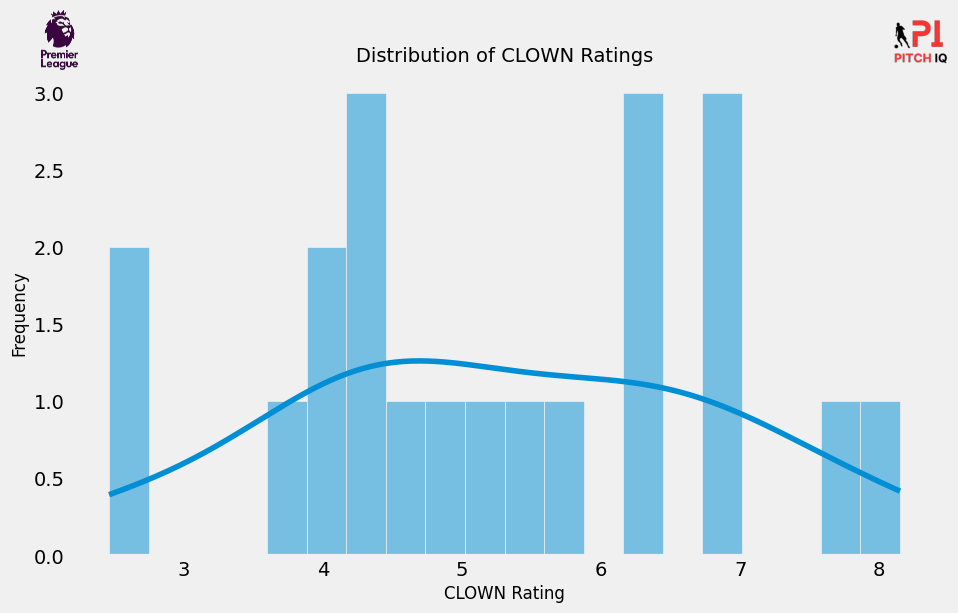

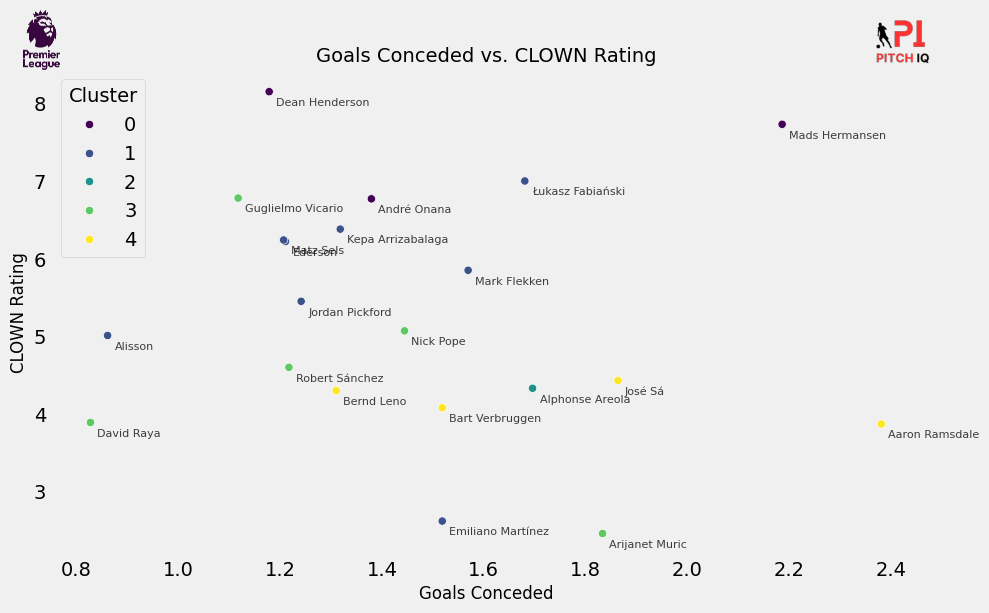

In [28]:
visualize_results(pl_clowns_cluster)

In [29]:
final_gk_df = pl_clowns_cluster[['Player', 'Squad', 'CLOWN_Rating', 'Cluster']].sort_values(by='CLOWN_Rating', ascending=False).reset_index(drop=True)
final_gk_df

,Player,Squad,CLOWN_Rating,Cluster
0,Dean Henderson,Crystal Palace,8.15,0
1,Mads Hermansen,Leicester City,7.73,0
2,Łukasz Fabiański,West Ham,7.00,1
3,Guglielmo Vicario,Tottenham,6.78,3
4,André Onana,Manchester Utd,6.77,0
5,Kepa Arrizabalaga,Bournemouth,6.38,1
6,Matz Sels,Nott'ham Forest,6.24,1
7,Ederson,Manchester City,6.22,1
8,Mark Flekken,Brentford,5.85,1
9,Jordan Pickford,Everton,5.45,1


In [37]:
fm_ids = pd.read_csv("/Users/stephenahiabah/Desktop/Code/cannoniq/CSVs/Top6_leagues_fotmob_ids.csv")
fm_ids = fm_ids[["team", "team_id"]]
fm_ids.rename(columns={"team": "Squad"}, inplace=True)

final_gk_df = final_gk_df.merge(fm_ids, on='Squad', how='left')
final_gk_df = final_gk_df.reset_index(drop=True)

In [38]:
# Define the mapping from Cluster to GK Style
cluster_to_style = {
    0: "Classic Shot-Stopper",  # Cluster 0
    1: "Sweeper-Keeper",       # Cluster 1
    2: "Balanced Goalkeeper",  # Cluster 2
    3: "Shot-Stopper with Aerial Dominance",  # Cluster 3
    4: "Modern Sweeper-Keeper"  # Cluster 4
}


# Add the GK_Style column to final_gk_df
final_gk_df['GK_Style'] = final_gk_df['Cluster'].map(cluster_to_style)


In [39]:
final_gk_df

,Player,Squad,CLOWN_Rating,Cluster,GK_Style,team_id
0,Mads Hermansen,Leicester City,8.25,0,Classic Shot-Stopper,8197
1,Łukasz Fabiański,West Ham,6.92,1,Sweeper-Keeper,8654
2,Dean Henderson,Crystal Palace,6.81,3,Shot-Stopper with Aerial Dominance,9826
3,Matz Sels,Nott'ham Forest,6.44,1,Sweeper-Keeper,10203
4,Alphonse Areola,West Ham,6.33,2,Balanced Goalkeeper,8654
5,André Onana,Manchester Utd,6.08,3,Shot-Stopper with Aerial Dominance,10260
6,Ederson,Manchester City,5.92,1,Sweeper-Keeper,8456
7,Kepa Arrizabalaga,Bournemouth,5.91,1,Sweeper-Keeper,8678
8,José Sá,Wolves,5.62,3,Shot-Stopper with Aerial Dominance,8602
9,Alisson,Liverpool,5.46,1,Sweeper-Keeper,8650


In [75]:
def perc_battery(clown_rating, ax):
    '''
    This function takes a CLOWN Rating (out of 10) and an axes, 
    and plots a battery chart.
    '''
    ax.set_xlim(0, 10)  # Set x-axis limit to 10 (since CLOWN Rating is out of 10)
    ax.set_ylim(0, 1)
    
    # Plot the background bar (full length)
    ax.barh([0.5], [10], fc='white', ec='black', height=0.35)
    
    # Plot the filled bar (based on CLOWN Rating)
    ax.barh([0.5], [clown_rating], fc='#00529F', height=0.35)
    
    # Add the CLOWN Rating text
    text_ = ax.annotate(
        xy=(clown_rating, 0.5),  # Position the text at the end of the filled bar
        text=f'{clown_rating:.1f}',  # Display the CLOWN Rating with 1 decimal place
        xytext=(-8, 0),  # Offset the text slightly to the left
        textcoords='offset points',
        weight='bold',
        color='#EFE9E6',
        va='center',
        ha='center',
        size=8
    )
    
    ax.set_axis_off()
    return ax

def ax_logo(team_id, ax):
    '''
    Plots the logo of the team at a specific axes.
    Args:
        team_id (int): the id of the team according to Fotmob. You can find it in the url of the team page.
        ax (object): the matplotlib axes where we'll draw the image.
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id}.png'))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

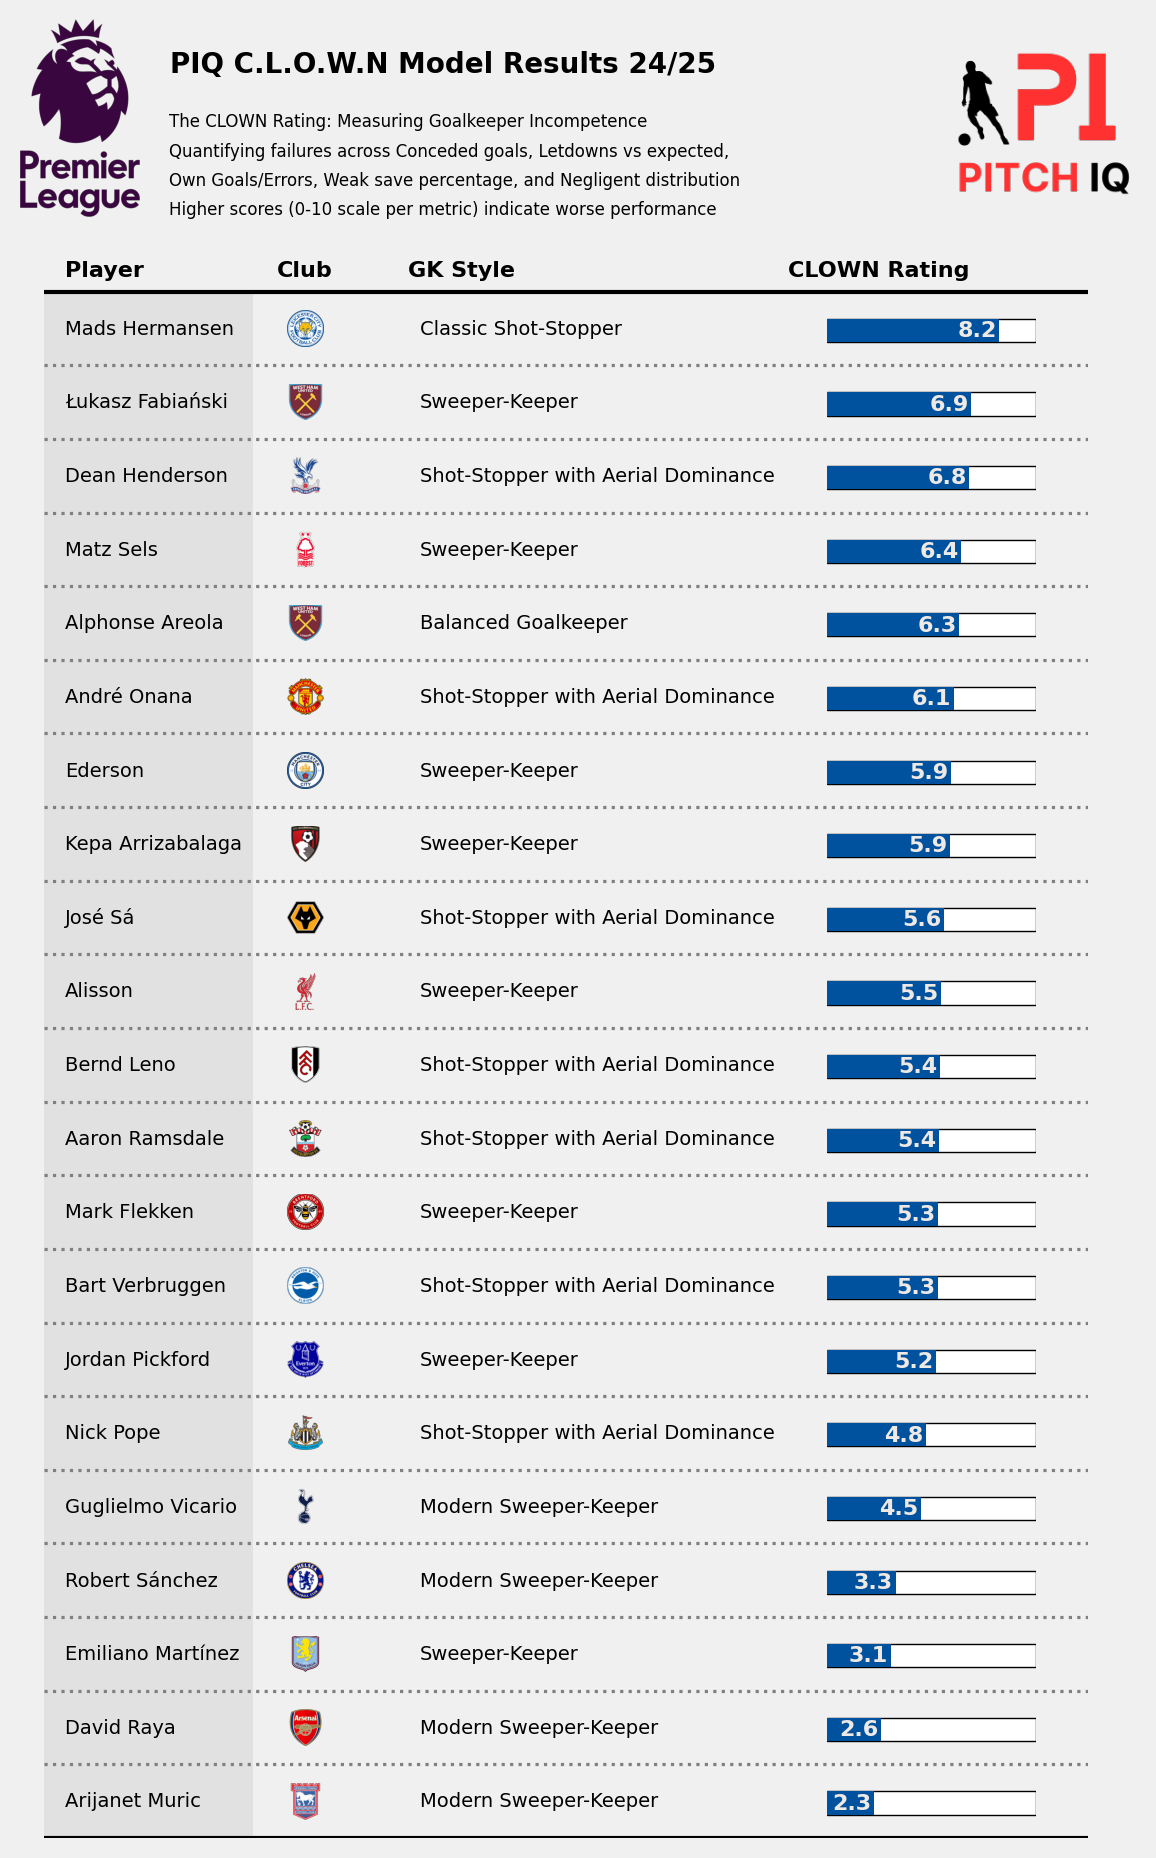

In [101]:
final_gk_df = final_gk_df.sort_values(by='CLOWN_Rating', ascending=True).reset_index(drop=True)
fig = plt.figure(figsize=(6, 10), dpi=200)
ax = plt.subplot()

ncols = 4
nrows = final_gk_df.shape[0]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows + 1)

# Define column positions
positions = [0.10, 1.25, 2.0, 4.0]  # Adjusted positions for alignment
columns = ['Player', 'team_id', 'GK_Style', 'CLOWN_Rating']

# Add table's main text

for i in range(nrows):
    for j, column in enumerate(columns):
        if column == 'team_id':
            continue  # Skip team_id for now (handled separately)
        ha = 'left'  # Left-align all columns
        text_label = f'{final_gk_df[column].iloc[i]}'
        weight = 'normal'
        if column == 'GK_Style':
            ax.annotate(
                xy=(positions[j] - 0.2, i + 0.5),  # Move GK Style text left
                text=text_label,
                ha=ha,
                va='center',
                size=7,
                weight=weight
            )
        else:
            ax.annotate(
                xy=(positions[j], i + 0.5),  # Keep other columns as is
                text=text_label,
                ha=ha,
                va='center',
                size=7,
                weight=weight
            )

# Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

# Add team logos (second column)
ax_point_1 = DC_to_NFC([1.0, 0.25])  # Adjusted position for logos
ax_point_2 = DC_to_NFC([1.5, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(nrows):
    ax_coords = DC_to_NFC([1.0, x + 0.25])  # Adjusted position for logos
    flag_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_width, ax_height])
    ax_logo(final_gk_df['team_id'].iloc[x], flag_ax)

# Add CLOWN_Rating progress bars (fourth column)
ax_point_1 = DC_to_NFC([3.75, 0.05])  # Adjusted position for progress bars
ax_point_2 = DC_to_NFC([4.75, 0.95])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(nrows):
    ax_coords = DC_to_NFC([3.75, x + 0.025])  # Adjusted position for progress bars
    bar_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_width, ax_height])
    perc_battery(final_gk_df['CLOWN_Rating'].iloc[x], bar_ax)

# Add column names
column_names = ['Player', 'Club', 'GK Style', 'CLOWN Rating']
for index, c in enumerate(column_names):
    if index == 0:
        ha = 'left'  # Left-align the Player column header
    else:
        ha = 'center'  # Center-align other column headers
    ax.annotate(
        xy=(positions[index], nrows + 0.15),
        text=column_names[index],
        ha=ha,
        va='bottom',
        size=8,
        weight='bold'
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3, marker='')

# Add shaded background for the first column
ax.fill_between(
    x=[0, 1],
    y1=nrows,
    y2=0,
    color='lightgrey',
    alpha=0.5,
    ec='None'
)

ax.set_axis_off()
# -- Final details
league_icon = Image.open("/Users/stephenahiabah/Desktop/Code/cannoniq/Images/premier-league-2-logo.png")
league_ax = fig.add_axes([0.06, 0.88, 0.10, 0.10], zorder=1)
league_ax.imshow(league_icon)
league_ax.axis("off")

ax.tick_params(axis='both', which='major', labelsize=8)

fig_text(
     x = 0.64, y = 0.95, 
    s = f'PIQ C.L.O.W.N Model Results 24/25',
    va = "bottom", ha = "right",
    fontsize = 10, color = "black", weight = "bold"
)

fig_text(
     x = 0.66, y = 0.88, 
    s = f'The CLOWN Rating: Measuring Goalkeeper Incompetence\nQuantifying failures across Conceded goals, Letdowns vs expected,\nOwn Goals/Errors, Weak save percentage, and Negligent distribution\nHigher scores (0-10 scale per metric) indicate worse performance​​​​​​​​​​​​​​​​',
    va = "bottom", ha = "right",
    fontsize = 6, color = "black", weight = "book"
)

### Add Stats by Steve logo
ax3 = fig.add_axes([0.83, 0.13, 0.16, 1.60])
ax3.axis('off')
img = plt.imread('/Users/stephenahiabah/Desktop/Code/cannoniq/Images/piqmain.png')
ax3.imshow(img)
plt.show()